Final Project 4501

In [76]:
# Import necessary libraries and modules
import geopandas as gpd
import json
import pathlib
import urllib.parse
import geoalchemy2 as gdb
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db
from sqlalchemy.orm import declarative_base
from shapely import wkt
import geopy
import geopandas as gpd
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')
import psycopg2
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from geoalchemy2 import Geometry
from pathlib import Path
from typing import Tuple, Dict, List, Union
from typing import Type
from pandas import DataFrame
import unittest

from shapely.geometry import Point
import matplotlib.pyplot as plt
from geopy.distance import distance
from sqlalchemy import create_engine,  MetaData, inspect, Column, Integer, Float, DateTime, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.engine.base import Engine
from matplotlib.animation import FuncAnimation
import contextily as ctx
from sqlalchemy.schema import CreateTable
import io



Part 1: Download, Read and Clean files  
1. downloading and reading tree and 311 files(when downloading 311, we use filter to only keep these columns: latitude,longitude,incident_zip,created_date,location,complaint_type), the 311 downloading was done on another notebook, thus only tree download code is shown as a desmontration.  
2. read 311  
3. read tree  
4. read zipcode  
5. raed zillow  
6. clean zipcode,zillow,tree,311

In [3]:

#read 311
file_311: gpd.GeoDataFrame = gpd.read_file('data/resource/nyc_311_data.geojson')


In [4]:
file_311.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24336507 entries, 0 to 24336506
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   latitude        object        
 1   created_date    datetime64[ns]
 2   longitude       object        
 3   incident_zip    object        
 4   complaint_type  object        
 5   geometry        geometry      
dtypes: datetime64[ns](1), geometry(1), object(4)
memory usage: 1.1+ GB


In [ ]:
#downloading tree from NYC open data
def download_nyc_geojson_data(url: str, token: str, force: bool = False) -> pathlib.Path:
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    filename = pathlib.Path("data") / url_path

    # Create directories if they don't exist
    filename.parent.mkdir(parents=True, exist_ok=True)
    
    if force or not filename.exists():
        print(f"Downloading {url} to {filename}...")
        
        # Set the initial offset
        offset = 0
        limit = 5000000
        
        while True:
            # Include the $limit and $offset parameters in the URL
            query = f"$limit={limit}&$offset={offset}"
            full_url = f"{url}?$$app_token={token}&{query}"

            # Make the request
            response = requests.get(full_url)
            
            # Print debugging information
            print(f"Response status code: {response.status_code}")
            print(f"Response content: {response.text}")

            # Check if the response is not empty
            if response.text:
                try:
                    # Attempt to parse JSON
                    json_data = response.json()
                    with open(filename, "a") as f:  # Append to the file instead of overwriting
                        json.dump(json_data, f)
                    print(f"Downloaded {len(json_data)} records from {url}.")
                    
                    # Check if there are more records
                    if len(json_data) < limit:
                        break
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON from {url}: {e}")
            else:
                print(f"Empty response received from {url}.")

            # Update the offset for the next page
            offset += limit

    else:
        print(f"Reading from {filename}...")

    return filename

# Set the URL and token
url: str = "https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson"
token: str = 'RQR8YRHhtzFqpNTQhQHZDzQUI'

# Use the function
geojson_file_tree: pathlib.Path = download_nyc_geojson_data(url, token)


Response status code: 200


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Downloaded 3 records from https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson.


In [ ]:
"""
    Download GeoJSON data from a specified URL and save it locally.

    This function downloads data from the given URL, which is expected to return GeoJSON data. It supports pagination through offset-based querying and saves the data in chunks to a local file. The data is saved in the 'data' directory with a filename derived from the URL path. If the 'force' flag is set or the file does not exist, the download is initiated; otherwise, the existing file is used.

    Parameters:
    url (str): The URL from which to download the data. It should return JSON data.
    token (str): An app token used for the API request.
    force (bool): If True, the data will be downloaded afresh even if it already exists. Defaults to False.

    Returns:
    pathlib.Path: The path to the file where the data is saved.

    Raises:
    json.JSONDecodeError: If there is an error in decoding the JSON data from the response.
    """
   

In [5]:
# Assuming geojson_file_tree is already defined as a pathlib.Path object
geojson_file_tree: pathlib.Path = download_nyc_geojson_data(url, token)

# Reading the GeoJSON file into a GeoDataFrame
file_tree: gpd.GeoDataFrame = gpd.read_file(geojson_file_tree)


In [4]:
#read zipcode
file_zipcode: gpd.GeoDataFrame = gpd.read_file('data/nyc_zipcodes.shp')

In [2]:
#read zillow
file_zillow: pd.DataFrame = pd.read_csv('data/zillow_rent_data.csv')

In [ ]:
file_311.head()

latitude        created_date           longitude incident_zip  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623        11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191        11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275        10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197        11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267        11226   

            complaint_type                    geometry  
0  Noise - Street/Sidewalk  POINT (-73.95918 40.65567)  
1      Noise - Residential  POINT (-73.78752 40.76676)  
2       Noise - Commercial  POINT (-73.98487 40.71950)  
3      Noise - Residential  POINT (-73.79729 40.68750)  
4      Noise - Residential  POINT (-73.95795 40.65220)

Steps for Cleaning:  
1.Clean zipcode first  
2.Clean zillow  
3.Clean tree  
4.Clean 311

In [5]:
#clean zipcode
# Step 1 - Renaming 'ZIPCODE' to 'zipcode'
zipcode_1: gpd.GeoDataFrame = file_zipcode.rename(columns={'ZIPCODE': 'zipcode'})

# Step 2 - Keeping useful columns
zipcode_keep_2: gpd.GeoDataFrame = zipcode_1[['zipcode', 'geometry']]

# Step 3 - Dropping duplicates
zipcode_dropduplicates_3: gpd.GeoDataFrame = zipcode_keep_2.drop_duplicates(subset='zipcode')

# Step 4 - Adjusting SRID and converting to a different coordinate system
cleaned_zipcode: gpd.GeoDataFrame = zipcode_dropduplicates_3.to_crs(epsg=4326)

# Displaying the first few rows of the cleaned GeoDataFrame
cleaned_zipcode.head()


zipcode                                           geometry
0   11436  POLYGON ((-73.80585 40.68291, -73.80569 40.682...
1   11213  POLYGON ((-73.93740 40.67973, -73.93487 40.679...
2   11212  POLYGON ((-73.90294 40.67084, -73.90223 40.668...
3   11225  POLYGON ((-73.95797 40.67066, -73.95576 40.670...
4   11218  POLYGON ((-73.97208 40.65060, -73.97192 40.650...

In [6]:
cleaned_zipcode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 248 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   248 non-null    object  
 1   geometry  248 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 5.8+ KB


In [115]:

#clean zillow 
# Step 1 - Renaming 'RegionName' to 'zipcode'
df_zillow_data_1: pd.DataFrame = file_zillow.rename(columns={'RegionName': 'zipcode'})

# Step 2 - Dropping unuseful columns
keep_column_zillow_2: pd.DataFrame = df_zillow_data_1.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'])

# Step 3 - Filling NA values with 0
fillna0_zillow_3: pd.DataFrame = keep_column_zillow_2.fillna(0)

# Step 4 - Filtering only the NYC zipcode and dropping duplicates
cleaned_zillow: pd.DataFrame = fillna0_zillow_3[fillna0_zillow_3['zipcode'].astype(str).isin(cleaned_zipcode['zipcode'].astype(str))]
cleaned_zillow.drop_duplicates(subset=['zipcode'], inplace=True)


In [141]:


# Inserting a new column 'id' at the beginning of the DataFrame
cleaned_zillow.insert(0, 'id', range(1, 1 + len(cleaned_zillow)))

# Displaying the first few rows of the modified DataFrame
cleaned_zillow.head()


id  index  zipcode  2015-01-31   2015-02-28  2015-03-31   2015-04-30  \
4    1      1    11385         0.0  2087.527084         0.0  2149.924252   
6    2      2    11208         0.0     0.000000         0.0     0.000000   
12   3      3    11236         0.0     0.000000         0.0     0.000000   
13   4      4    10467         0.0     0.000000         0.0     0.000000   
14   5      5    11373         0.0     0.000000         0.0     0.000000   

     2015-05-31   2015-06-30   2015-07-31  ...   2022-12-31   2023-01-31  \
4   2166.263698  2148.992886  2190.098591  ...  2935.808220  2895.699421   
6      0.000000     0.000000     0.000000  ...  2508.670432  2588.030194   
12     0.000000     0.000000     0.000000  ...     0.000000     0.000000   
13     0.000000     0.000000     0.000000  ...  2145.642295  2155.617718   
14     0.000000     0.000000     0.000000  ...  2199.459063  2255.604528   

     2023-02-28   2023-03-31   2023-04-30   2023-05-31   2023-06-30  \
4   2873.209025  2881.906361  2913.546218  2963.964134  3005.735342   
6   2613.790654  2585.561351  2633.200754  2672.038493  2806.918757   
12     0.000000     0.000000     0.000000     0.000000     0.000000   
13  2172.346611  2160.962748  2110.533203  2180.323655  2276.372290   
14  2262.101623  2271.514956  2250.182334  2231.959479  2257.413993   

     2023-07-31   2023-08-31   2023-09-30  
4   3034.413822  3064.476503  3079.585783  
6   2765.224364  2737.547470  2728.733333  
12     0.000000  2285.460026  2362.500000  
13  2334.204728  2353.686402  2423.888889  
14  2247.592851  2302.557354  2292.994444  

[5 rows x 108 columns]

In [123]:
cleaned_zillow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 4 to 6721
Columns: 107 entries, index to 2023-09-30
dtypes: float64(105), int64(2)
memory usage: 123.2 KB


In [32]:

#clean tree 

# Renaming columns and keeping specific columns in the tree data
tree_columns_tokeep: gpd.GeoDataFrame = file_tree[['tree_id', 'latitude', 'longitude', 'spc_common', 'zipcode', 'health', 'status', 'geometry']].rename(columns={'spc_common': 'species'})

# Filtering trees based on the zipcode list from cleaned_zipcode
tree_filter_zipcode: gpd.GeoDataFrame = tree_columns_tokeep[tree_columns_tokeep['zipcode'].astype(str).isin(cleaned_zipcode['zipcode'].astype(str))]

# Dropping rows with missing values
cleaned_tree: gpd.GeoDataFrame = tree_filter_zipcode.dropna()


In [33]:
cleaned_tree.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 652167 entries, 0 to 683787
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   tree_id    652167 non-null  object  
 1   latitude   652167 non-null  object  
 2   longitude  652167 non-null  object  
 3   species    652167 non-null  object  
 4   zipcode    652167 non-null  object  
 5   health     652167 non-null  object  
 6   status     652167 non-null  object  
 7   geometry   652167 non-null  geometry
dtypes: geometry(1), object(7)
memory usage: 44.8+ MB


In [34]:
cleaned_tree.head()

tree_id     latitude     longitude          species zipcode health status  \
0  180683  40.72309177  -73.84421522        red maple   11375   Fair  Alive   
1  200540  40.79411067  -73.81867946          pin oak   11357   Fair  Alive   
2  204026  40.71758074   -73.9366077      honeylocust   11211   Good  Alive   
3  204337  40.71353749  -73.93445616      honeylocust   11211   Good  Alive   
4  189565  40.66677776  -73.97597938  American linden   11215   Good  Alive   

                     geometry  
0  POINT (-73.84422 40.72309)  
1  POINT (-73.81868 40.79411)  
2  POINT (-73.93661 40.71758)  
3  POINT (-73.93446 40.71354)  
4  POINT (-73.97598 40.66678)

In [ ]:
##clean 311
file_311.head()

latitude        created_date           longitude incident_zip  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623        11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191        11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275        10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197        11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267        11226   

            complaint_type                    geometry  
0  Noise - Street/Sidewalk  POINT (-73.95918 40.65567)  
1      Noise - Residential  POINT (-73.78752 40.76676)  
2       Noise - Commercial  POINT (-73.98487 40.71950)  
3      Noise - Residential  POINT (-73.79729 40.68750)  
4      Noise - Residential  POINT (-73.95795 40.65220)

In [23]:

#clean 311 
# Renaming columns in file_311
rename_311: pd.DataFrame = file_311.rename(columns={'incident_zip': 'zipcode'})

# Dropping duplicates in renamed DataFrame
dropduplicate_311: pd.DataFrame = rename_311.drop_duplicates()

# Filtering only the NYC zipcode and creating the cleaned DataFrame
cleaned_311: pd.DataFrame = dropduplicate_311[dropduplicate_311['zipcode'].astype(str).isin(cleaned_zipcode['zipcode'].astype(str))]

# Displaying the first few rows of the cleaned DataFrame
cleaned_311.head()


latitude        created_date           longitude zipcode  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623   11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191   11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275   10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197   11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267   11226   

            complaint_type                    geometry  
0  Noise - Street/Sidewalk  POINT (-73.95918 40.65567)  
1      Noise - Residential  POINT (-73.78752 40.76676)  
2       Noise - Commercial  POINT (-73.98487 40.71950)  
3      Noise - Residential  POINT (-73.79729 40.68750)  
4      Noise - Residential  POINT (-73.95795 40.65220)

In [24]:
# Dropping rows with missing values
cleaned_311: pd.DataFrame = cleaned_311.dropna()


In [ ]:
cleaned_311.head()

latitude        created_date           longitude ZIPCODE  \
0  40.655672001198894 2023-09-30 23:59:58  -73.95917686020623   11226   
1   40.76675595839554 2023-09-30 23:59:38  -73.78751847563191   11361   
2   40.71949965458691 2023-09-30 23:59:35  -73.98486650733275   10002   
3  40.687499303408536 2023-09-30 23:59:34   -73.7972903094197   11435   
4   40.65220215349917 2023-09-30 23:59:28   -73.9579464603267   11226   

            complaint_type                    geometry  
0  Noise - Street/Sidewalk  POINT (-73.95918 40.65567)  
1      Noise - Residential  POINT (-73.78752 40.76676)  
2       Noise - Commercial  POINT (-73.98487 40.71950)  
3      Noise - Residential  POINT (-73.79729 40.68750)  
4      Noise - Residential  POINT (-73.95795 40.65220)

Part2 Storing Data  
1. Create database  
2. Create engine  
3. Read data into tables 

In [ ]:
##create database
!/Applications/Postgres.app/Contents/Versions/latest/bin/createdb FinalProject4501
!/Applications/Postgres.app/Contents/Versions/latest/bin/psql --dbname FinalProject4501 -c 'CREATE EXTENSION postgis;'


CREATE EXTENSION


Create tables and insert data


In [25]:
# Create a PostgreSQL database connection using psycopg2
conn = psycopg2.connect('postgresql://localhost/FinalProject4501')

# Create a SQLAlchemy engine for the same database
engine = create_engine('postgresql://localhost/FinalProject4501')


In [13]:
def convert_geodf_for_sql(geodf: gpd.GeoDataFrame, geometry_type: str = 'POINT', srid: int = 4326) -> Tuple[gpd.GeoDataFrame, Dict[str, Geometry]]:
    # Create a copy of the input GeoDataFrame to avoid modifying the original data
    geodf_for_sql: gpd.GeoDataFrame = geodf.copy()

    # Check if the current CRS is not EPSG:4326 (WGS 84)
    if geodf_for_sql.crs.to_epsg() != 4326:
        # If not, convert the GeoDataFrame to EPSG:4326
        geodf_for_sql = geodf_for_sql.to_crs(epsg=4326)

    # Convert the geometry column of the GeoDataFrame to Well-Known Text (WKT) format
    geodf_for_sql['geometry'] = geodf_for_sql['geometry'].apply(lambda x: x.wkt)

    # Create a dictionary specifying the SQL data type for the geometry column
    dtype: Dict[str, Geometry] = {'geometry': Geometry(geometry_type=geometry_type, srid=srid)}

    # Return the modified GeoDataFrame and the SQL data type dictionary
    return geodf_for_sql, dtype


In [14]:

    """Converts a GeoDataFrame for SQL storage by converting its geometry column to WKT format.

    This function takes a GeoDataFrame, converts its geometry column to Well-Known Text (WKT) format,
    and ensures that the Coordinate Reference System (CRS) is set to EPSG:4326 for SQL compatibility.

    Args:
        geodf (GeoDataFrame): The GeoDataFrame to be converted.
        geometry_type (str, optional): The geometry type for the resulting SQL column (e.g., 'POINT', 'LINESTRING'). Defaults to 'POINT'.
        srid (int, optional): The Spatial Reference Identifier (SRID) for the resulting SQL column. Defaults to 4326 (EPSG:4326).

    Returns:
        Tuple[GeoDataFrame, Dict[str, Geometry]]: A tuple containing the converted GeoDataFrame and a dictionary specifying the SQL data type.
            The dictionary has the format {'geometry': Geometry(geometry_type=geometry_type, srid=srid)}.
    """

"Converts a GeoDataFrame for SQL storage by converting its geometry column to WKT format.\n\nThis function takes a GeoDataFrame, converts its geometry column to Well-Known Text (WKT) format,\nand ensures that the Coordinate Reference System (CRS) is set to EPSG:4326 for SQL compatibility.\n\nArgs:\n    geodf (GeoDataFrame): The GeoDataFrame to be converted.\n    geometry_type (str, optional): The geometry type for the resulting SQL column (e.g., 'POINT', 'LINESTRING'). Defaults to 'POINT'.\n    srid (int, optional): The Spatial Reference Identifier (SRID) for the resulting SQL column. Defaults to 4326 (EPSG:4326).\n\nReturns:\n    Tuple[GeoDataFrame, Dict[str, Geometry]]: A tuple containing the converted GeoDataFrame and a dictionary specifying the SQL data type.\n        The dictionary has the format {'geometry': Geometry(geometry_type=geometry_type, srid=srid)}.\n"

In [ ]:

# SQL schema definition
three11_SCHEMA: str = """
CREATE TABLE IF NOT EXISTS three11s(
    id SERIAL PRIMARY KEY, 
    created_date DATE,
    complaint_type VARCHAR(200),
    zipcode VARCHAR(200),
    latitude FLOAT,
    longitude FLOAT,
    geometry GEOMETRY (POINT, 4326)
);
"""

# Executing the SQL command
with engine.connect() as connection:
    connection.execute(three11_SCHEMA)
    connection.execute("COMMIT;")

# Assuming cleaned_311 is a GeoDataFrame and convert_geodf_for_sql is defined
cleaned_311: gpd.GeoDataFrame # Define or load your cleaned_311 GeoDataFrame

# Converting GeoDataFrame for SQL
three11_sql: gpd.GeoDataFrame
zip_dtype: Dict[str, Geometry]
three11_sql, zip_dtype = convert_geodf_for_sql(cleaned_311)

# Uploading DataFrame to SQL
three11_sql.to_sql('three11s', engine, if_exists='append', index=False, dtype=zip_dtype)


In [ ]:

# SQL schema definition for zipcodes
ZIPCODE_SCHEMA: str = """
CREATE TABLE IF NOT EXISTS zipcodes (
    zipcode VARCHAR(200) PRIMARY KEY, 
    geometry GEOMETRY (POLYGON, 4326)
);
"""

# Executing the SQL command
with engine.connect() as connection:
    connection.execute(ZIPCODE_SCHEMA)
    connection.execute("COMMIT;")

# Assuming cleaned_zipcode is a GeoDataFrame and convert_geodf_for_sql is defined
cleaned_zipcode: gpd.GeoDataFrame = ... # Define or load your cleaned_zipcode GeoDataFrame

# Converting GeoDataFrame for SQL
zipcode_sql: gpd.GeoDataFrame
zip_dtype: Dict[str, Geometry]
zipcode_sql, zip_dtype = convert_geodf_for_sql(cleaned_zipcode, 'POLYGON', 4326)

# Uploading DataFrame to SQL
zipcode_sql.to_sql('zipcodes', engine, if_exists='append', index=False, dtype=zip_dtype)


In [36]:

# SQL schema definition for trees
TREE_SCHEMA: str = """
CREATE TABLE IF NOT EXISTS trees (
    tree_id INT PRIMARY KEY,
    latitude FLOAT,
    longitude FLOAT,
    species VARCHAR(60),
    zipcode VARCHAR(60),
    health VARCHAR(60),
    status VARCHAR(60),
    geometry GEOMETRY (POINT, 4326)
);
"""

# Executing the SQL command
with engine.connect() as connection:
    connection.execute(TREE_SCHEMA)
    connection.execute("COMMIT;")


In [37]:
# Convert the cleaned tree GeoDataFrame to SQL-compatible format
tree_sql: gpd.GeoDataFrame
zip_dtype: Dict[str, Geometry]
tree_sql, zip_dtype = convert_geodf_for_sql(cleaned_tree)

# Uploading the DataFrame to the SQL database
# The 'trees' table is used for storing tree data in the SQL database

# 'tree_sql' is the GeoDataFrame containing tree data in SQL-compatible format.
# 'engine' is the SQLAlchemy engine for the SQL database connection.

# The 'to_sql' method is used to upload the 'tree_sql' GeoDataFrame to the 'trees' table in the SQL database.
# - 'if_exists='append'' specifies that if the table already exists in the database, the data should be appended.
# - 'index=False' ensures that the DataFrame index is not included as a separate column in the table.
# - 'dtype=zip_dtype' specifies the SQL data type for the geometry column, ensuring it is stored correctly in the database.

tree_sql.to_sql('trees', engine, if_exists='append', index=False, dtype=zip_dtype)


167

Read zillow using a different way since there are 106 columns

In [142]:
# Create a base class for declarative ORM models
Base = declarative_base()

# Define a SQLAlchemy model class for the 'zillows' table
class Zillow(Base):
    # Specify the table name
    __tablename__ = 'zillows'
    
    # Define columns of the 'zillows' table
    id = Column(Integer, primary_key=True, nullable=False)

# Function to define the schema of the SQLAlchemy model based on a DataFrame
def define_schema_from_dataframe(df: DataFrame, cls: type) -> None:
    # Iterate through columns of the DataFrame
    for col, dtype in zip(df.columns, df.dtypes):
        # Skip the 'id' column (assuming it's the primary key)
        if col == 'id':
            continue
        
        # Check the data type of the column in the DataFrame
        if dtype == np.int64:
            # If it's an integer, create an Integer column in the SQLAlchemy model
            setattr(cls, col, Column(col, Integer()))
        elif dtype == np.float64:
            # If it's a float, create a Float column in the SQLAlchemy model
            setattr(cls, col, Column(col, Float()))
        elif dtype == 'datetime64[ns]':
            # If it's a datetime, create a DateTime column in the SQLAlchemy model
            setattr(cls, col, Column(col, DateTime()))
        else: 
            # For other data types, create a String column in the SQLAlchemy model
            setattr(cls, col, Column(col, String()))



# Check if the table 'zillows' already exists in the database
if Zillow.__table__.exists(bind=engine):
    # If it exists, drop the table to recreate it with the new schema
    Zillow.__table__.drop(engine)
    
# Create the tables in the database based on the defined schema
Base.metadata.create_all(engine)


In [21]:

    """
    Define a SQLAlchemy schema class based on the columns of a DataFrame.

    This function automatically generates SQLAlchemy column definitions for a schema class (cls)
    based on the columns and data types of a DataFrame (df). It inspects the DataFrame's columns
    and assigns corresponding SQLAlchemy column types to each column in the schema class.

    Args:
        df (pandas.core.frame.DataFrame): The DataFrame from which the schema is generated.
        cls (sqlalchemy.orm.decl_api.DeclarativeMeta): The SQLAlchemy declarative base class
            to which the columns will be added.

    Returns:
        None

    Raises:
        None
    """

"\nDefine a SQLAlchemy schema class based on the columns of a DataFrame.\n\nThis function automatically generates SQLAlchemy column definitions for a schema class (cls)\nbased on the columns and data types of a DataFrame (df). It inspects the DataFrame's columns\nand assigns corresponding SQLAlchemy column types to each column in the schema class.\n\nArgs:\n    df (pandas.core.frame.DataFrame): The DataFrame from which the schema is generated.\n    cls (sqlalchemy.orm.decl_api.DeclarativeMeta): The SQLAlchemy declarative base class\n        to which the columns will be added.\n\nReturns:\n    None\n\nRaises:\n    None\n"

In [104]:
# Define a unit test case class for testing the 'define_schema_from_dataframe' function
class TestDefineSchemaFromDataFrame(unittest.TestCase):
    def test_define_schema(self) -> None:
        # Create a sample DataFrame
        data: dict = {
            'id': [1, 2], 
            'int_column': [10, 20], 
            'float_column': [1.1, 2.2], 
            'datetime_column': [datetime.now(), datetime.now()],
            'string_column': ['a', 'b']
        }
        df: DataFrame = pd.DataFrame(data)

        # Define a dummy class to serve as the SQLAlchemy model class
        class DummyClass:
            pass

        # Apply the 'define_schema_from_dataframe' function to define schema for 'DummyClass'
        define_schema_from_dataframe(df, DummyClass)

        # Assertions to check if the schema was correctly defined
        self.assertTrue(hasattr(DummyClass, 'int_column') and isinstance(getattr(DummyClass, 'int_column').type, Integer))
        self.assertTrue(hasattr(DummyClass, 'float_column') and isinstance(getattr(DummyClass, 'float_column').type, Float))
        self.assertTrue(hasattr(DummyClass, 'datetime_column') and isinstance(getattr(DummyClass, 'datetime_column').type, DateTime))
        self.assertTrue(hasattr(DummyClass, 'string_column') and isinstance(getattr(DummyClass, 'string_column').type, String))

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestDefineSchemaFromDataFrame)

# Run the tests
unittest.TextTestRunner().run(suite)



.
----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [22]:
class TestDefineSchemaFromDataFrame:
    """
    Unit tests for the define_schema_from_dataframe function.
    """

    def test_define_schema(self):
        """
        Test that the define_schema_from_dataframe function correctly defines SQLAlchemy schema.

        This test case creates a sample DataFrame, applies the function to define a schema class,
        and verifies that the generated schema class has the expected columns with the correct types.

        Args:
            None

        Returns:
            None

        Raises:
            AssertionError: If the test fails to verify the schema's correctness.
        """

In [143]:
# Define the schema for the 'Zillow' table in the database based on the structure of the 'cleaned_zillow' DataFrame.
# This function maps the columns and data types of 'cleaned_zillow' to the SQLAlchemy model 'Zillow' class,
# allowing the DataFrame structure to be used as the schema definition for the database table.
define_schema_from_dataframe(cleaned_zillow, Zillow)

# Upload 'cleaned_zillow' to 'zillows' table
cleaned_zillow.to_sql('zillows', con=engine, if_exists='replace', index=False)

146

In [146]:
# Create a metadata object
metadata = MetaData()

# Bind the metadata to the engine
metadata.bind = engine

# Create an IO stream to capture the SQL statement
buffer = io.StringIO()

# Generate the SQL for the 'zillows' table
create_table_statement = CreateTable(Zillow.__table__)

# Write the SQL statement to the buffer
buffer.write(str(create_table_statement.compile(engine)))

# create schema.sql file
SCHEMA_FILE = "schema.sql"
with open(SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(three11_SCHEMA)
    f.write(TREE_SCHEMA)
    f.write(buffer.getvalue())

# Close the buffer
buffer.close()

Till now, all table creating and inserting is done! Let's check for results:

In [105]:

# Check for table trees
test_trees_srid: str = '''SELECT ST_SRID(geometry) FROM trees LIMIT 2;'''
test_trees_primary_key: str = '''SELECT column_name, is_nullable
    FROM information_schema.columns
    WHERE table_name = 'trees';'''
test_trees_dtypes: str = '''SELECT column_name, udt_name
    FROM information_schema.columns
    WHERE table_name = 'trees';'''

# Executing SQL queries and storing results in DataFrames
test_tree1: DataFrame = pd.read_sql(test_trees_srid, engine)
test_tree2: DataFrame = pd.read_sql(test_trees_primary_key, engine)
test_tree3: DataFrame = pd.read_sql(test_trees_dtypes, engine)

# Printing the results
print(test_tree1)
print(test_tree2)
print(test_tree3)


   st_srid
0     4326
1     4326
  column_name is_nullable
0     tree_id          NO
1    latitude         YES
2   longitude         YES
3    geometry         YES
4     zipcode         YES
5      health         YES
6      status         YES
7     species         YES
  column_name  udt_name
0     tree_id      int4
1    latitude    float8
2   longitude    float8
3    geometry  geometry
4     zipcode   varchar
5      health   varchar
6      status   varchar
7     species   varchar


In [106]:
# Check 'three11s' table in the database.
# These queries check the SRID of the geometry column, the primary key columns, and the data types of all columns.

# Query to check the SRID (Spatial Reference Identifier) of the geometry column in 'three11s' table.
test_three11s_srid: str = '''SELECT ST_SRID(geometry) FROM three11s LIMIT 1;'''

# Query to check the primary key columns and their nullability in 'three11s' table.
test_three11s_primary_key: str = '''SELECT column_name, is_nullable
    FROM information_schema.columns
    WHERE table_name = 'three11s';'''

# Query to check the data types of all columns in 'three11s' table.
test_three11s_dtypes: str = '''SELECT column_name, udt_name
    FROM information_schema.columns
    WHERE table_name = 'three11s';'''

# Executing the SQL queries and storing the results in DataFrames.
test_three11s1: DataFrame = pd.read_sql(test_three11s_srid, engine)  # SRID information
test_three11s2: DataFrame = pd.read_sql(test_three11s_primary_key, engine)  # Primary key information
test_three11s3: DataFrame = pd.read_sql(test_three11s_dtypes, engine)  # Data types of columns

# Printing the results for inspection or verification.
print(test_three11s1)  # SRID of the geometry column
print(test_three11s2)  # Primary key columns and nullability
print(test_three11s3)  # Data types of all columns



   st_srid
0     4326
      column_name is_nullable
0       longitude         YES
1        geometry         YES
2    created_date         YES
3              id          NO
4        latitude         YES
5         zipcode         YES
6  complaint_type         YES
      column_name  udt_name
0       longitude    float8
1        geometry  geometry
2    created_date      date
3              id      int4
4        latitude    float8
5         zipcode   varchar
6  complaint_type   varchar


In [107]:
# Check for 'zipcodes' table in the database.
# These queries check the SRID of the geometry column, the primary key columns, and the data types of all columns.

# Query to check the SRID (Spatial Reference Identifier) of the geometry column in 'zipcodes' table.
test_zipcodes_srid: str = '''SELECT ST_SRID(geometry) FROM zipcodes LIMIT 1;'''

# Query to check the primary key columns and their nullability in 'zipcodes' table.
test_zipcodes_primary_key: str = '''SELECT column_name, is_nullable
    FROM information_schema.columns
    WHERE table_name = 'zipcodes';'''

# Query to check the data types of all columns in 'zipcodes' table.
test_zipcodes_dtypes: str = '''SELECT column_name, udt_name
    FROM information_schema.columns
    WHERE table_name = 'zipcodes';'''

# Executing the SQL queries and storing the results in DataFrames.
test_zipcodes1: DataFrame = pd.read_sql(test_zipcodes_srid, engine)  # SRID information
test_zipcodes2: DataFrame = pd.read_sql(test_zipcodes_primary_key, engine)  # Primary key information
test_zipcodes3: DataFrame = pd.read_sql(test_zipcodes_dtypes, engine)  # Data types of columns

# Printing the results for inspection or verification.
print(test_zipcodes1)  # SRID of the geometry column
print(test_zipcodes2)  # Primary key columns and nullability
print(test_zipcodes3)  # Data types of all columns


   st_srid
0     4326
  column_name is_nullable
0    geometry         YES
1     zipcode          NO
  column_name  udt_name
0    geometry  geometry
1     zipcode   varchar


In [145]:
# Query to check the data types of all columns in 'zillows' table.
test_zillows_primary_key: str = '''SELECT column_name, is_nullable
    FROM information_schema.columns
    WHERE table_name = 'zillows';'''
test_zillows_dtypes: str = '''SELECT column_name, udt_name
    FROM information_schema.columns
    WHERE table_name = 'zillows';'''

# Executing the SQL queries and storing the results in DataFrames.
test_zillows2: DataFrame = pd.read_sql(test_zillows_primary_key, engine)  # Data types of columns

test_zillows3: DataFrame = pd.read_sql(test_zillows_dtypes, engine)  # Data types of columns

# Printing the results for inspection or verification.
print(test_zillows2)
print(test_zillows3)  # Data types of all columns


    column_name is_nullable
0            id          NO
1       zipcode         YES
2    2015-01-31         YES
3    2015-02-28         YES
4    2015-03-31         YES
..          ...         ...
102  2023-05-31         YES
103  2023-06-30         YES
104  2023-07-31         YES
105  2023-08-31         YES
106  2023-09-30         YES

[107 rows x 2 columns]
    column_name udt_name
0            id     int8
1       zipcode     int8
2    2015-01-31   float8
3    2015-02-28   float8
4    2015-03-31   float8
..          ...      ...
102  2023-05-31   float8
103  2023-06-30   float8
104  2023-07-31   float8
105  2023-08-31   float8
106  2023-09-30   float8

[107 rows x 2 columns]


In [147]:
#1. 
# Assuming engine is already defined as a SQLAlchemy Engine instance
engine: Engine = create_engine('postgresql://localhost/FinalProject4501')

# SQL query string and file path for the query
query1: str = 'data/q1_complaints_per_zip.sql'
query: str = """
SELECT e.zipcode, COUNT(*) AS ComplaintCount
FROM  Three11s e
WHERE e.created_date >= '2022-10-01' AND e.created_date <= '2023-09-30'
GROUP BY e.zipcode
ORDER BY ComplaintCount DESC;
"""

# Writing query to file
with open(query1, 'w') as file:
    file.write(query)

# Executing SQL query and storing results in a DataFrame
q1_complaints_per_zip: DataFrame = pd.read_sql(query, engine)

# Displaying the DataFrame
q1_complaints_per_zip


zipcode  complaintcount
0     11226           46540
1     10467           44898
2     11385           42974
3     10468           42239
4     10452           41460
..      ...             ...
226   10155               4
227   00083               2
228   10055               2
229   10080               1
230   10175               1

[231 rows x 2 columns]

In [148]:
2.
# SQL query string and file path for the query
query2: str = 'data/q2_top_trees_zipcodes.sql'
query: str = """
SELECT zipcode, COUNT(*) AS NumberOfTrees
FROM trees
GROUP BY zipcode
ORDER BY NumberOfTrees DESC
LIMIT 10;
"""

# Writing query to file
with open(query2, 'w') as file:
    file.write(query)

# Executing SQL query and storing results in a DataFrame
q2_top_trees_zipcodes: DataFrame = pd.read_sql(query, engine)

# Displaying the DataFrame
q2_top_trees_zipcodes


zipcode  numberoftrees
0   10312          21356
1   10314          16330
2   10306          12616
3   10309          12105
4   11234          10838
5   11385          10262
6   11357           9016
7   11207           8293
8   11208           7896
9   11434           7833

In [149]:
#3
# SQL query string and file path for the query
query3: str = 'data/q3_affordable_trees_area.sql'
query: str = """
WITH TopTreeZipCodes AS (
    SELECT zipcode, COUNT(*) AS total_trees
    FROM trees
    GROUP BY zipcode
    ORDER BY COUNT(*) DESC
    LIMIT 10
)
SELECT t.zipcode, TO_CHAR(AVG(z."2023-08-31"), 'FM9,999,999.99') AS average_rent
FROM TopTreeZipCodes t
JOIN zillows z ON t.zipcode::bigint= z.zipcode
GROUP BY t.zipcode, t.total_trees
ORDER BY t.total_trees DESC;
"""

# Writing query to file
with open(query3, 'w') as file:
    file.write(query)

# Executing SQL query and storing results in a DataFrame
q3_affordable_trees_area: DataFrame = pd.read_sql(query, engine)

# Displaying the DataFrame
print(q3_affordable_trees_area)


  zipcode average_rent
0   10312     1,775.09
1   10314     2,465.47
2   10306     2,331.54
3   10309     1,832.01
4   11234     2,312.31
5   11385     3,064.48
6   11357     2,458.81
7   11207     3,079.09
8   11208     2,737.55
9   11434     2,645.92


In [150]:
4.
# SQL query string and file path for the query
query4: str = 'data/q4_rent_tree_complaint.sql'
query: str = """
WITH Rent AS (
    SELECT zipcode, AVG("2023-01-31") AS average_rent
    FROM zillows
    GROUP BY zipcode
    HAVING AVG("2023-01-31") > 0 -- Exclude ZIP codes with an average rent of 0
),
TreeCount AS (
    SELECT zipcode::bigint, COUNT(*) as tree_count
    FROM trees
    GROUP BY zipcode
),
ComplaintCount AS (
    SELECT zipcode::bigint, COUNT(*) as complaint_count
    FROM three11s
    WHERE created_date >= '2023-01-01' AND created_date <= '2023-01-31'
    GROUP BY zipcode
),
RankedRent AS (
    SELECT zipcode, TO_CHAR(average_rent, 'FM9,999,999.99') AS formatted_average_rent, average_rent,
           DENSE_RANK() OVER (ORDER BY average_rent DESC) AS high_rank,
           DENSE_RANK() OVER (ORDER BY average_rent ASC) AS low_rank
    FROM Rent
)

SELECT rr.zipcode, rr.formatted_average_rent, tc.tree_count, cc.complaint_count
FROM RankedRent rr
LEFT JOIN TreeCount tc ON rr.zipcode = tc.zipcode
LEFT JOIN ComplaintCount cc ON rr.zipcode = cc.zipcode
WHERE rr.high_rank <= 5 OR rr.low_rank <= 5
ORDER BY rr.average_rent DESC, rr.high_rank, rr.low_rank;
"""

# Writing query to file
with open(query4, 'w') as file:
    file.write(query)

# Executing SQL query and storing results in a DataFrame
q4_rent_tree_complaint: DataFrame = pd.read_sql(query, engine)

# Displaying the DataFrame
print(q4_rent_tree_complaint)


   zipcode formatted_average_rent  tree_count  complaint_count
0    10007               7,270.24         338              232
1    10282               7,143.35         230               42
2    10013               5,480.11        1132              747
3    10069               4,959.67         112               36
4    10011               4,741.87        2040             1474
5    10458               1,883.08        3212             3556
6    11357               1,829.66        9016              876
7    10453               1,820.23        2874             2864
8    10462               1,801.89        4048             2253
9    10309               1,380.51       12105              793


In [47]:
# Checking if the geometry can be converted to human-readable form
task: str = """
SELECT ST_AsText(geometry) FROM trees LIMIT 1;
"""

# Executing SQL query and storing results in a DataFrame
df: DataFrame = pd.read_sql(task, engine)

# Displaying the DataFrame
print(df)


                                      st_astext
0  POINT(-73.84421521958048 40.723091773924274)


In [151]:
#5
query5: str = 'data/q5_most_greenery_zipcodes.sql'
query: str = """
SELECT z.zipcode, COUNT(t.tree_id) AS total_trees
FROM zipcodes z 
JOIN trees t ON z.zipcode = t.zipcode 
WHERE ST_Within(t.geometry, z.geometry)
GROUP BY z.zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

# Writing query to file
with open(query5, 'w') as file:
    file.write(query)

# Executing SQL query and storing results in a DataFrame
q5_most_greenery_zipcodes: DataFrame = pd.read_sql(query, engine)

# Displaying the DataFrame
print(q5_most_greenery_zipcodes)

  zipcode  total_trees
0   10312        21356
1   10314        16330
2   10306        12616
3   10309        12105
4   11234        10838
5   11385        10262
6   11357         9016
7   11207         8293
8   11208         7896
9   11434         7833


In [152]:
#6
# SQL query string and file path for the query
query6: str = 'data/q6_trees_within_half_mile.sql'
query: str = """
SELECT trees.tree_id, trees.species, trees.health, trees.status, ST_AsText(trees.geometry) AS coordinates
FROM trees 
WHERE ST_DWithin(
    ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326)::geography,
    ST_Transform(trees.geometry, 4326)::geography,
    0.5 * 1609.34 -- Convert 0.5 miles to meters
)
"""

# Writing query to file
with open(query6, 'w') as file:
    file.write(query)

# Executing SQL query and storing results in a DataFrame
q6_trees_within_half_mile: DataFrame = pd.read_sql(query, engine)

# Displaying the DataFrame
print(q6_trees_within_half_mile)


      tree_id           species health status  \
0      198514           pin oak   Good  Alive   
1      209919  London planetree   Good  Alive   
2      209921  London planetree   Good  Alive   
3      203887        willow oak   Good  Alive   
4      196440      American elm   Fair  Alive   
...       ...               ...    ...    ...   
2767   198518  London planetree   Fair  Alive   
2768   198513  northern red oak   Good  Alive   
2769   203890  Japanese zelkova   Good  Alive   
2770   187102           pin oak   Fair  Alive   
2771   203998  London planetree   Good  Alive   

                                       coordinates  
0      POINT(-73.96207980385901 40.80230108588602)  
1     POINT(-73.96331506361766 40.808811547267055)  
2      POINT(-73.96340334087577 40.80874458097537)  
3     POINT(-73.96071917063361 40.805725833688264)  
4      POINT(-73.96412322243684 40.81114537770991)  
...                                            ...  
2767   POINT(-73.96153780795652 40.80207

In [153]:
#1.
# Function to retrieve the top complaint types from the database.
# It returns a list of the top 3 complaint types based on the highest count of complaints
# recorded between October 1, 2022, and September 30, 2023.

def get_top_complaint_types(engine: Engine) -> List[str]:
    # SQL query to fetch the top complaint types
    query: str = """
    SELECT complaint_type, COUNT(*) AS count
    FROM three11s
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 3;
    """
    # Execute the SQL query and store the results in a DataFrame
    top_complaints: pd.DataFrame = pd.read_sql(query, engine)
    
    # Extract and return the complaint types as a list
    return top_complaints['complaint_type'].tolist()


# Call the function to get the top complaint types
top_complaint_types: List[str] = get_top_complaint_types(engine)

# Print the top complaint types for inspection or use
print(top_complaint_types)


['Illegal Parking', 'Noise - Residential', 'HEAT/HOT WATER']


In [154]:
#unit test
class TestGetTopComplaintTypes(unittest.TestCase):
    def test_top_complaint_types(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Call the function
        top_complaint_types = get_top_complaint_types(engine)

        # Assertions
        self.assertIsInstance(top_complaint_types, list, "Output should be a list")
        self.assertEqual(len(top_complaint_types), 3, "List should contain exactly three items")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestGetTopComplaintTypes)

# Run the tests
unittest.TextTestRunner().run(suite)


.
----------------------------------------------------------------------
Ran 1 test in 1.224s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [54]:
class TestGetTopComplaintTypes(unittest.TestCase):
    """
    A unit test suite for the get_top_complaint_types function.
    """

    def test_top_complaint_types(self):
        """
        Test the get_top_complaint_types function.

        This test case initializes a test database engine, calls the get_top_complaint_types function,
        and verifies that it returns a list with exactly three items.

        Args:
            engine (sqlalchemy.engine.base.Engine): SQLAlchemy engine for connecting to the database.

        Returns:
            None

        Raises:
            AssertionError: If the function returns an unexpected result, this test case will fail.
        """


In [155]:

    """
    Retrieves the top three complaint types based on their frequency over a specified period.

    This function executes a SQL query to find the most common complaint types in the 'three11' table
    within a one-year period, from October 1, 2022, to September 30, 2023. It returns a list of the top 
    three complaint types sorted in descending order of occurrence.

    Args:
    - engine: The SQLAlchemy engine object used for database connection and query execution.

    Returns:
    - A list of strings, where each string is a complaint type. The list contains the top three 
      complaint types occurring most frequently in the specified date range.

    Example:
    >>> engine = create_engine('postgresql://localhost/FinalProject4501')
    >>> top_complaint_types = get_top_complaint_types(engine)
    >>> print(top_complaint_types)
    ['Noise - Residential', 'Illegal Parking', 'Blocked Driveway']

    Note:
    - The function assumes that the 'three11' table and the specified date range exist in the database.
    - The function uses pandas to execute the SQL query and process the result.
    """
 


"\nRetrieves the top three complaint types based on their frequency over a specified period.\n\nThis function executes a SQL query to find the most common complaint types in the 'three11' table\nwithin a one-year period, from October 1, 2022, to September 30, 2023. It returns a list of the top \nthree complaint types sorted in descending order of occurrence.\n\nArgs:\n- engine: The SQLAlchemy engine object used for database connection and query execution.\n\nReturns:\n- A list of strings, where each string is a complaint type. The list contains the top three \n  complaint types occurring most frequently in the specified date range.\n\nExample:\n>>> engine = create_engine('postgresql://localhost/FinalProject4501')\n>>> top_complaint_types = get_top_complaint_types(engine)\n>>> print(top_complaint_types)\n['Noise - Residential', 'Illegal Parking', 'Blocked Driveway']\n\nNote:\n- The function assumes that the 'three11' table and the specified date range exist in the database.\n- The funct

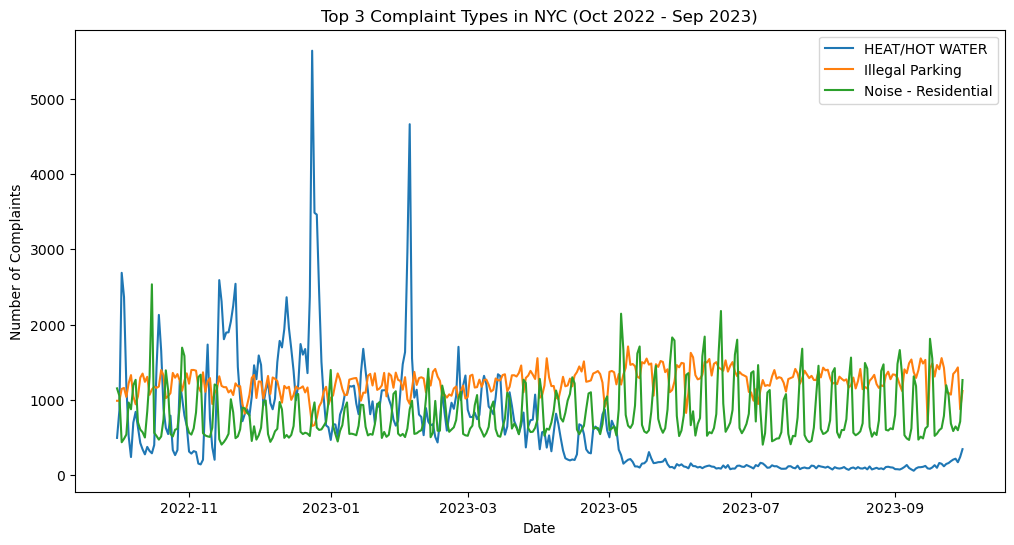

In [156]:
# Function to plot the daily count of the top complaint types in NYC between October 2022 and September 2023.
# It takes an SQLAlchemy Engine instance and a list of top complaint types as input.

def plot_complaint_types(engine: Engine, top_complaint_types: List[str]) -> None:
    # Format the list of complaint types for SQL query
    complaint_types_str: str = "'" + "', '".join(top_complaint_types) + "'"

    # Updated SQL query to fetch daily complaint counts for the specified complaint types
    query: str = f"""
    SELECT created_date, complaint_type, COUNT(*) AS daily_count
    FROM three11s
    WHERE complaint_type IN ({complaint_types_str})
    AND created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY created_date, complaint_type;
    """
    
    # Execute the SQL query and store the results in a DataFrame
    df: DataFrame = pd.read_sql(query, engine)

    # Pivot the DataFrame to prepare for plotting
    pivot_df: DataFrame = df.pivot(index='created_date', columns='complaint_type', values='daily_count')

    # Plotting the daily counts for each complaint type
    plt.figure(figsize=(12, 6))
    for column in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[column], label=column)

    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.title('Top 3 Complaint Types in NYC (Oct 2022 - Sep 2023)')
    plt.legend()
    plt.show()


# Assuming 'top_complaint_types' is a list of strings obtained from the 'get_top_complaint_types' function
top_complaint_types: List[str] = get_top_complaint_types(engine)

# Call the function to plot the top complaint types
plot_complaint_types(engine, top_complaint_types)


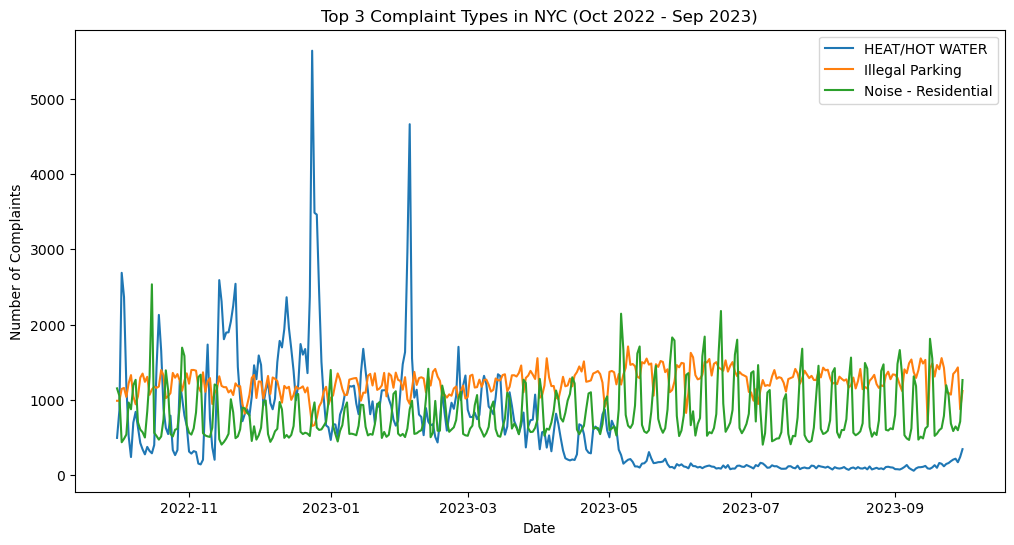

.
----------------------------------------------------------------------
Ran 1 test in 1.426s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [157]:
#unit test
class TestPlotComplaintTypes(unittest.TestCase):
    def test_plot_complaint_types(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Example top complaint types
        top_complaint_types = ['Illegal Parking', 'Noise - Residential', 'HEAT/HOT WATER']

        # Initialize the variable to None
        raised_exception = None
        
        # Call the function inside a try-except block to catch exceptions
        try:
            plot_complaint_types(engine, top_complaint_types)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotComplaintTypes)

# Run the tests
unittest.TextTestRunner().run(suite)

In [57]:
class TestPlotComplaintTypes(unittest.TestCase):
    """
    A unit test suite for the plot_complaint_types function.
    """

    def test_plot_complaint_types(self):
        """
        Test the plot_complaint_types function.

        This test case initializes a test database engine, calls the plot_complaint_types function
        with example top complaint types, and verifies that it can be executed without raising an exception.

        Args:
            engine (sqlalchemy.engine.base.Engine): SQLAlchemy engine for connecting to the database.

        Returns:
            None

        Raises:
            AssertionError: If the function raises an exception, this test case will fail.
        """

In [158]:
    """
    Generates a time-series plot of the daily count of top complaint types over a specified period.

    This function queries the 'three11' table in the database to fetch the daily count of complaints 
    for each of the top complaint types provided. It plots these counts over the time period from 
    October 1, 2022, to September 30, 2023. The function then visualizes this data in a line plot, 
    where each line represents one of the top complaint types.

    Args:
    - engine: The SQLAlchemy engine object for database connection and query execution.
    - top_complaint_types: A list of strings representing the top complaint types to be plotted.
    
    Returns:
    None
    
    The function:
    - Formats the list of top complaint types for inclusion in a SQL query.
    - Executes a SQL query to retrieve the daily count of each complaint type within the specified date range.
    - Transforms the query results into a pivot table for easy plotting.
    - Generates a line plot with dates on the x-axis and complaint counts on the y-axis.

    Example:
    >>> engine = create_engine('postgresql://localhost/FinalProject4501')
    >>> top_complaint_types = ['Noise - Residential', 'Illegal Parking', 'Blocked Driveway']
    >>> plot_complaint_types(engine, top_complaint_types)

    Note:
    - The function assumes that the 'three11' table and the specified date range exist in the database.
    - It utilizes pandas for data manipulation and Matplotlib for plotting.
    - This function does not return any value; it directly displays the plot.
    """
    # Function implementation...


"\nGenerates a time-series plot of the daily count of top complaint types over a specified period.\n\nThis function queries the 'three11' table in the database to fetch the daily count of complaints \nfor each of the top complaint types provided. It plots these counts over the time period from \nOctober 1, 2022, to September 30, 2023. The function then visualizes this data in a line plot, \nwhere each line represents one of the top complaint types.\n\nArgs:\n- engine: The SQLAlchemy engine object for database connection and query execution.\n- top_complaint_types: A list of strings representing the top complaint types to be plotted.\n\nReturns:\nNone\n\nThe function:\n- Formats the list of top complaint types for inclusion in a SQL query.\n- Executes a SQL query to retrieve the daily count of each complaint type within the specified date range.\n- Transforms the query results into a pivot table for easy plotting.\n- Generates a line plot with dates on the x-axis and complaint counts on

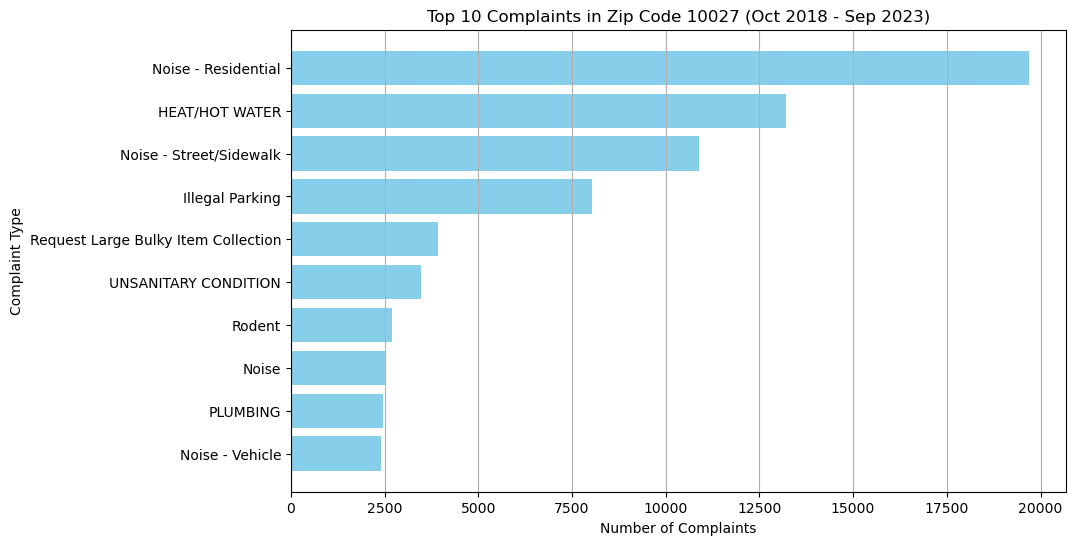

In [159]:
#2
def plot_top_complaints_in_zipcode(engine: Engine) -> None:
    # SQL query string
    query: str = """
    SELECT complaint_type, COUNT(*) AS count
    FROM three11s
    WHERE zipcode = '10027' 
    AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT 10;
    """
    df: DataFrame = pd.read_sql(query, engine)

    # Sorting the DataFrame for better visualization
    df.sort_values(by='count', ascending=True, inplace=True)

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(df['complaint_type'], df['count'], color='skyblue')
    plt.xlabel('Number of Complaints')
    plt.ylabel('Complaint Type')
    plt.title('Top 10 Complaints in Zip Code 10027 (Oct 2018 - Sep 2023)')
    plt.grid(axis='x')
    plt.show()


# Call the function with the engine
plot_top_complaints_in_zipcode(engine)


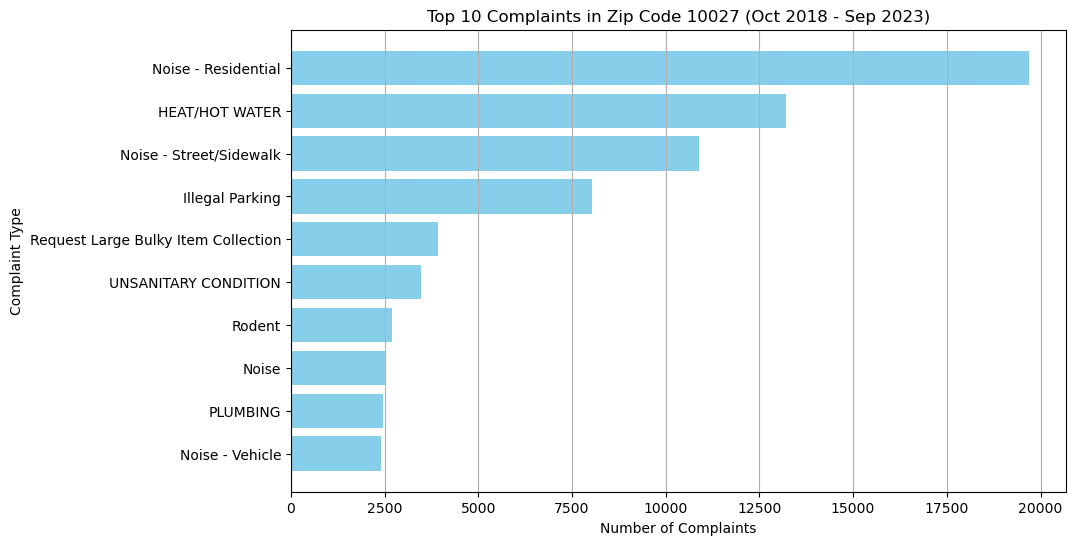

.
----------------------------------------------------------------------
Ran 1 test in 1.421s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [160]:
#unit test
class TestPlotTopComplaintsInZipcode(unittest.TestCase):
    def test_plot_top_complaints_in_zipcode(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Initialize the variable to None
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_top_complaints_in_zipcode(engine)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotTopComplaintsInZipcode)

# Run the tests
unittest.TextTestRunner().run(suite)

In [60]:
class TestPlotTopComplaintsInZipcode(unittest.TestCase):
    """
    A unit test suite for the plot_top_complaints_in_zipcode function.
    """

    def test_plot_top_complaints_in_zipcode(self):
        """
        Test the plot_top_complaints_in_zipcode function.

        This test case initializes a test database engine, calls the plot_top_complaints_in_zipcode function,
        and verifies that it can be executed without raising an exception.

        Args:
            engine (sqlalchemy.engine.base.Engine): SQLAlchemy engine for connecting to the database.

        Returns:
            None

        Raises:
            AssertionError: If the function raises an exception, this test case will fail.
        """

In [161]:
    """
    Generates a bar chart showing the top 10 complaint types in zip code 10027 over a specified period.

    This function queries the 'three11' table in the database to retrieve the count of different complaint 
    types in zip code 10027 from October 1, 2018, to September 30, 2023. The top 10 complaint types based 
    on frequency are then visualized in a horizontal bar chart. The chart displays complaint types along 
    the y-axis and their corresponding counts along the x-axis.

    Args:
    - engine: The SQLAlchemy engine object for database connection and query execution.

    Returns:
    None 

    The function:
    - Executes a SQL query to fetch the count of each complaint type in the specified zip code and date range.
    - Sorts the resulting data in ascending order for a more readable bar chart.
    - Generates a horizontal bar chart using Matplotlib, with customized aesthetics such as color and grid lines.

    Example:
    >>> engine = create_engine('postgresql://localhost/FinalProject4501')
    >>> plot_top_complaints_in_zipcode(engine)

    Note:
    - The function assumes the 'three11' table is present in the database with relevant data.
    - It uses pandas for data handling and Matplotlib for plotting.
    - This function does not return any value; it directly displays the plot.
    """


"\nGenerates a bar chart showing the top 10 complaint types in zip code 10027 over a specified period.\n\nThis function queries the 'three11' table in the database to retrieve the count of different complaint \ntypes in zip code 10027 from October 1, 2018, to September 30, 2023. The top 10 complaint types based \non frequency are then visualized in a horizontal bar chart. The chart displays complaint types along \nthe y-axis and their corresponding counts along the x-axis.\n\nArgs:\n- engine: The SQLAlchemy engine object for database connection and query execution.\n\nReturns:\nNone \n\nThe function:\n- Executes a SQL query to fetch the count of each complaint type in the specified zip code and date range.\n- Sorts the resulting data in ascending order for a more readable bar chart.\n- Generates a horizontal bar chart using Matplotlib, with customized aesthetics such as color and grid lines.\n\nExample:\n>>> engine = create_engine('postgresql://localhost/FinalProject4501')\n>>> plot_to

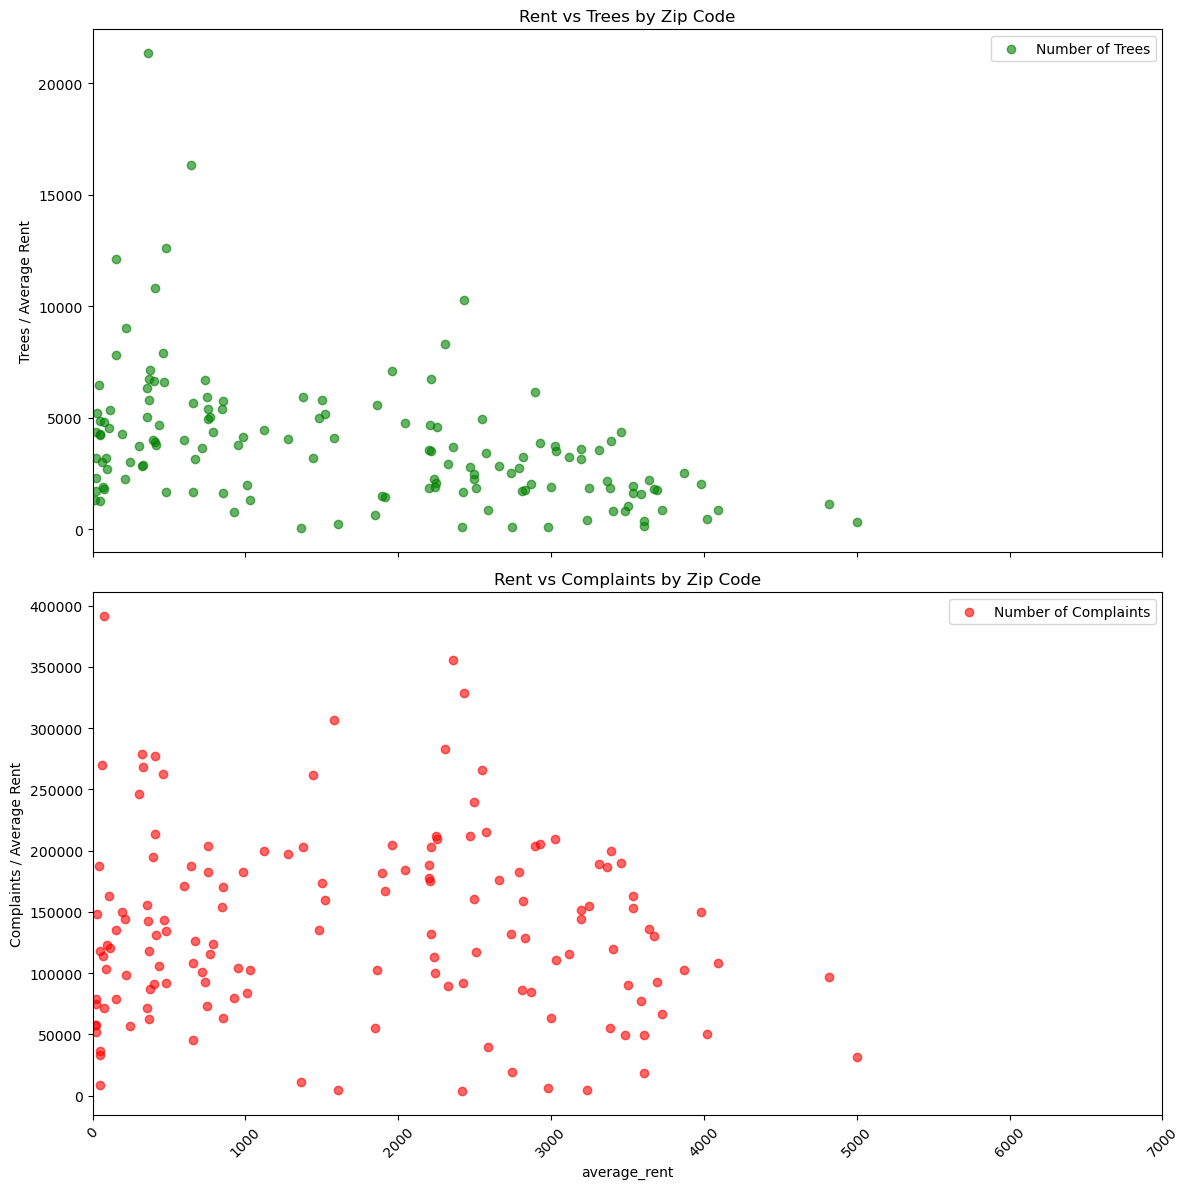

In [162]:
#3
engine = db.create_engine('postgresql://localhost/FinalProject4501')
# Database setup

def plot_rent_trees_complaints(engine):
    rent_query: str= """
    SELECT zipcode,
    ((AVG("2015-01-31") + AVG("2015-02-28") + AVG("2015-03-31")+
    AVG("2015-04-30") + AVG("2015-05-31") + AVG("2015-06-30") +
    AVG("2015-07-31") + AVG("2015-08-31") + AVG("2015-09-30") +
    AVG("2015-10-31") + AVG("2015-11-30") + AVG("2015-12-31") +
    AVG("2016-01-31") + AVG("2016-02-29") + AVG("2016-03-31") +
    AVG("2016-04-30") + AVG("2016-05-31") + AVG("2016-06-30") +
    AVG("2016-07-31") + AVG("2016-08-31") + AVG("2016-09-30") +
    AVG("2016-10-31") + AVG("2016-11-30") + AVG("2016-12-31") +
    AVG("2017-01-31") + AVG("2017-02-28") + AVG("2017-03-31") +
    AVG("2017-04-30") + AVG("2017-05-31") + AVG("2017-06-30") +
    AVG("2017-07-31") + AVG("2017-08-31") + AVG("2017-09-30") +
    AVG("2017-10-31") + AVG("2017-11-30") + AVG("2017-12-31") +
    AVG("2018-01-31") + AVG("2018-02-28") + AVG("2018-03-31") +
    AVG("2018-04-30") + AVG("2018-05-31") + AVG("2018-06-30") +
    AVG("2018-07-31") + AVG("2018-08-31") + AVG("2018-09-30") +
    AVG("2018-10-31") + AVG("2018-11-30") + AVG("2018-12-31") +
    AVG("2019-01-31") + AVG("2019-02-28") + AVG("2019-03-31") +
    AVG("2019-04-30") + AVG("2019-05-31") + AVG("2019-06-30") +
    AVG("2019-07-31") + AVG("2019-08-31") + AVG("2019-09-30") +
    AVG("2019-10-31") + AVG("2019-11-30") + AVG("2019-12-31") +
    AVG("2020-01-31") + AVG("2020-02-29") + AVG("2020-03-31") +
    AVG("2020-04-30") + AVG("2020-05-31") + AVG("2020-06-30") +
    AVG("2020-07-31") + AVG("2020-08-31") + AVG("2020-09-30") +
    AVG("2020-10-31") + AVG("2020-11-30") + AVG("2020-12-31") +
    AVG("2021-01-31") + AVG("2021-02-28") + AVG("2021-03-31") +
    AVG("2021-04-30") + AVG("2021-05-31") + AVG("2021-06-30") +
    AVG("2021-07-31") + AVG("2021-08-31") + AVG("2021-09-30") +
    AVG("2021-10-31") + AVG("2021-11-30") + AVG("2021-12-31") +
    AVG("2022-01-31") + AVG("2022-02-28") + AVG("2022-03-31") +
    AVG("2022-04-30") + AVG("2022-05-31") + AVG("2022-06-30") +
    AVG("2022-07-31") + AVG("2022-08-31") + AVG("2022-09-30") +
    AVG("2022-10-31") + AVG("2022-11-30") + AVG("2022-12-31") +
    AVG("2023-01-31") + AVG("2023-02-28") + AVG("2023-03-31") +
    AVG("2023-04-30") + AVG("2023-05-31") + AVG("2023-06-30") +
    AVG("2023-07-31") + AVG("2023-08-31") + AVG("2023-09-30")) / 105) AS average_rent
    FROM zillows
    GROUP BY zipcode;
    """

    tree_query: str = """
    SELECT zipcode, COUNT(*) AS tree_count
    FROM trees
    GROUP BY zipcode;
    """
    complaint_query: str = """
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM three11s
    WHERE created_date BETWEEN '2015-01-01' AND '2023-09-30'
    GROUP BY zipcode;
    """

    # Fetching data from the database
    rent_df: DataFrame = pd.read_sql(rent_query, engine)
    tree_df: DataFrame = pd.read_sql(tree_query, engine)
    complaint_df: DataFrame = pd.read_sql(complaint_query, engine)

    # Convert ZIPCODE columns to string and merging
    rent_df['zipcode'] = rent_df['zipcode'].astype(str)
    tree_df['zipcode'] = tree_df['zipcode'].astype(str)
    complaint_df['zipcode'] = complaint_df['zipcode'].astype(str)
    merged_df: DataFrame = pd.merge(pd.merge(rent_df, tree_df, on='zipcode'), complaint_df, on='zipcode')
    
 
# Merge the dataframes on ZIPCODE
    merged_df = pd.merge(pd.merge(rent_df, tree_df, on='zipcode'), complaint_df, on='zipcode')
    
# Rest of your code for plotting...  
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Rent vs. Number of Trees
    ax1.scatter(merged_df['average_rent'], merged_df['tree_count'], color='g', alpha=0.6, label='Number of Trees')
    #ax1.scatter(merged_df['zipcode'], merged_df['average_rent'], color='b', alpha=0.6, label='Average Rent')
    ax1.set_ylabel('Trees / Average Rent')
    ax1.set_title('Rent vs Trees by Zip Code')
    ax1.legend()

# Rent vs. Number of Complaints
    ax2.scatter(merged_df['average_rent'], merged_df['complaint_count'], color='r', alpha=0.6, label='Number of Complaints')
    #ax2.scatter(merged_df['zipcode'], merged_df['average_rent'], color='b', alpha=0.6, label='Average Rent')
    ax2.set_xlabel('average_rent')
    ax2.set_ylabel('Complaints / Average Rent')
    ax2.set_title('Rent vs Complaints by Zip Code')
    ax2.legend()

# Set the limits of the x-axis
    plt.xlim(0, 7000) 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_rent_trees_complaints(engine)

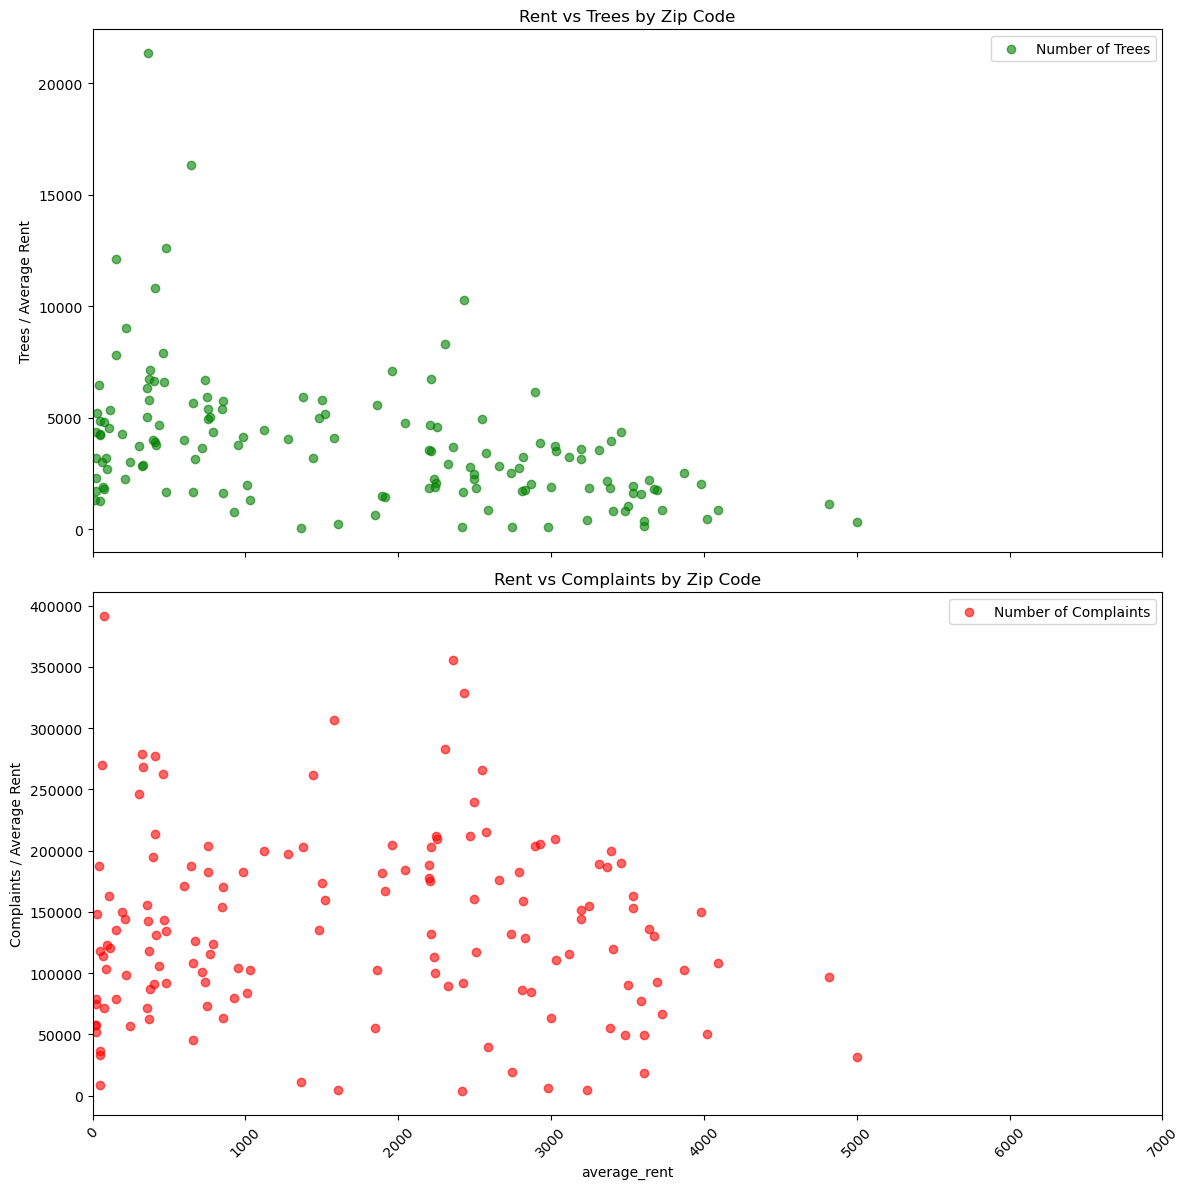

.
----------------------------------------------------------------------
Ran 1 test in 2.406s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [163]:
#unit test
class TestPlotRentTreesComplaints(unittest.TestCase):
    def test_plot_rent_trees_complaints(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Initialize the variable to None
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_rent_trees_complaints(engine)
            exception_raised = False
        except Exception as e:
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotRentTreesComplaints)

# Run the tests
unittest.TextTestRunner().run(suite)

In [63]:

def plot_rent_trees_complaints(engine):
    """
    Plot relationships between average rent, the number of trees, and the number of complaints by zip code.

    This function retrieves data from a PostgreSQL database using the provided engine.
    It calculates the average rent, counts the number of trees and complaints by zip code,
    and creates scatter plots to visualize the relationships.

    Args:
        engine (sqlalchemy.engine.base.Engine): SQLAlchemy engine for connecting to the database.

    Returns:
        None
    """

In [64]:
class TestPlotRentTreesComplaints(unittest.TestCase):
    """
    A unit test suite for the plot_rent_trees_complaints function.
    """

    def test_plot_rent_trees_complaints(self):
        """
        Test the plot_rent_trees_complaints function.

        This test case initializes a test database engine, calls the plot_rent_trees_complaints function,
        and verifies that it can be executed without raising an exception.

        Args:
            engine (sqlalchemy.engine.base.Engine): SQLAlchemy engine for connecting to the database.

        Returns:
            None

        Raises:
            AssertionError: If the function raises an exception, this test case will fail.
        """

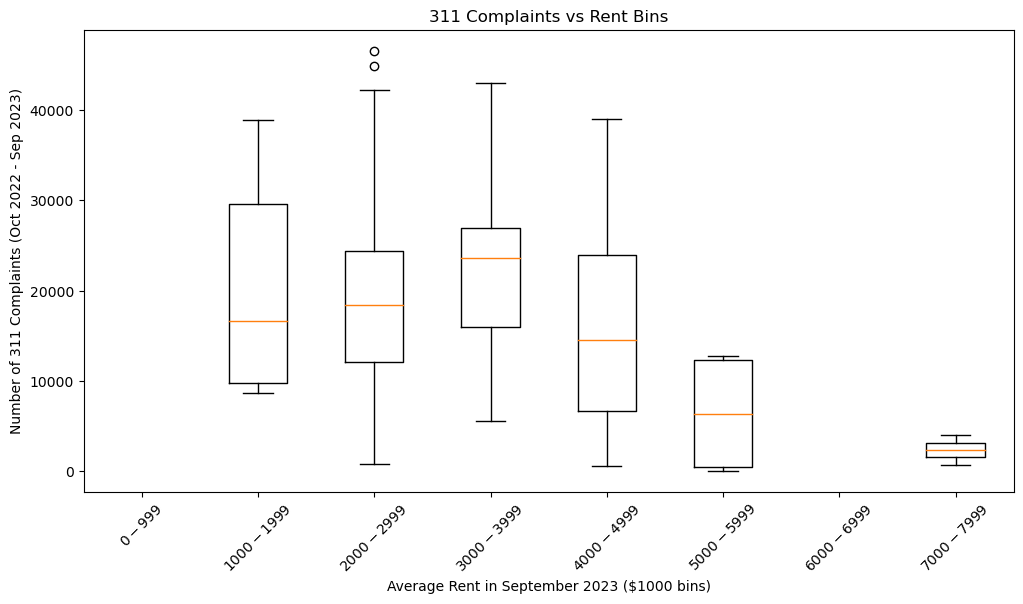

In [164]:
#4
def plot_rent_vs_complaints(engine: Engine) -> None:
    # SQL queries as strings
    rent_query: str = """
    SELECT zipcode, "2023-09-30" AS average_rent_september_2023
    FROM zillows;
    """
    complaint_query: str = """
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM three11s
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY zipcode;
    """

    # Read data from the database
    rent_df: DataFrame = pd.read_sql(rent_query, engine)
    complaint_df: DataFrame = pd.read_sql(complaint_query, engine)

    # Convert 'zipcode' to string in both DataFrames
    rent_df['zipcode'] = rent_df['zipcode'].astype(str)
    complaint_df['zipcode'] = complaint_df['zipcode'].astype(str)

    # Merge the dataframes on ZIPCODE
    merged_df: DataFrame = pd.merge(rent_df, complaint_df, on='zipcode')

    # Check if max_rent is NaN or None
    max_rent: float = merged_df['average_rent_september_2023'].max()
    if pd.isna(max_rent):
        print("No rent data available for September 2023.")
        return

    # Creating bins for rent
    bins: np.ndarray = np.arange(0, max_rent + 1000, 1000)
    merged_df['rent_bin'] = pd.cut(merged_df['average_rent_september_2023'], bins=bins, right=False)

    # Creating the boxplot
    plt.figure(figsize=(12, 6))
    boxplot_data: List = [group['complaint_count'] for name, group in merged_df.groupby('rent_bin')]
    boxplot_labels: List[str] = [f"${int(interval.left)}-${int(interval.right)-1}" for interval in merged_df['rent_bin'].cat.categories]
    plt.boxplot(boxplot_data, labels=boxplot_labels)
    plt.xlabel('Average Rent in September 2023 ($1000 bins)')
    plt.ylabel('Number of 311 Complaints (Oct 2022 - Sep 2023)')
    plt.title('311 Complaints vs Rent Bins')
    plt.xticks(rotation=45)
    plt.show()


# Call the function with the engine
plot_rent_vs_complaints(engine)


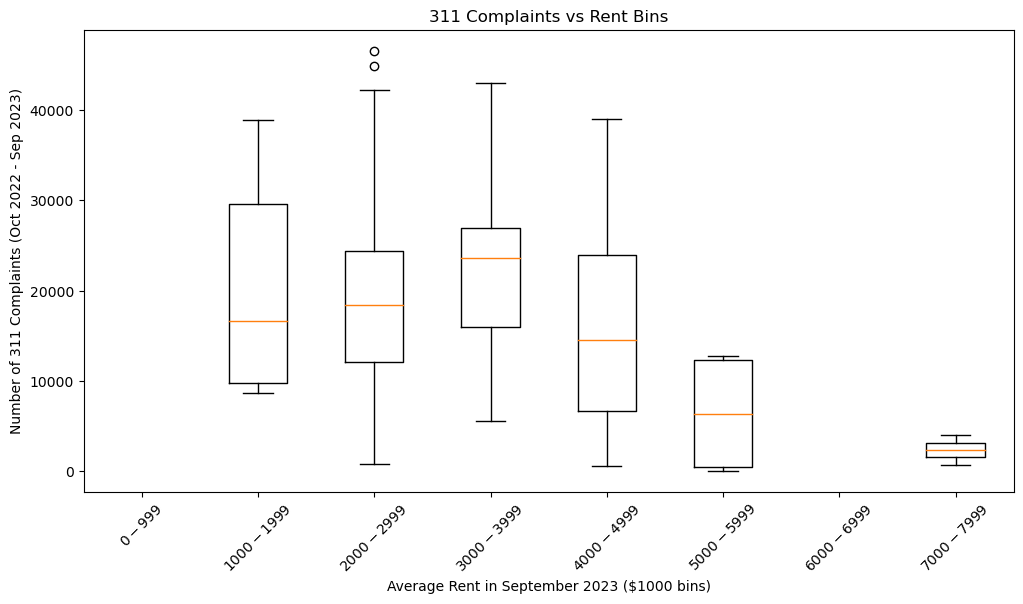

.
----------------------------------------------------------------------
Ran 1 test in 1.388s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [165]:
#unit test
class TestPlotRentVsComplaints(unittest.TestCase):
    def test_plot_rent_vs_complaints(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Initialize the variable to None to capture any raised exceptions
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_rent_vs_complaints(engine)
            exception_raised = False
        except Exception as e:
            # Set exception_raised to True and store the raised exception
            exception_raised = True
            raised_exception = e

        # Assertions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotRentVsComplaints)

# Run the tests
unittest.TextTestRunner().run(suite)


Animation for Visualization 4

In [166]:
#Animation:
%matplotlib notebook

engine = create_engine('postgresql://localhost/FinalProject4501')

def plot_rent_vs_complaints_animation(engine):
    # SQL queries with the correct column names
    rent_query = """
    SELECT zipcode, "2023-09-30" AS average_rent_september_2023
    FROM zillows;
    """
    complaint_query = """
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM three11s
    WHERE "created_date" BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY zipcode;
    """

    rent_df = pd.read_sql(rent_query, engine)
    complaint_df = pd.read_sql(complaint_query, engine)

    # Convert 'zipcode' to string in both DataFrames
    rent_df['zipcode'] = rent_df['zipcode'].astype(str)
    complaint_df['zipcode'] = complaint_df['zipcode'].astype(str)

    
    # Merge the dataframes on zipcode
    merged_df = pd.merge(rent_df, complaint_df, on='zipcode')

    # Check if max_rent is NaN or None
    max_rent = merged_df['average_rent_september_2023'].max()
    if pd.isna(max_rent):
        print("No rent data available for September 2023.")
        return None

    # Creating bins for rent
    bins = np.arange(0, max_rent + 1000, 1000)
    merged_df['rent_bin'] = pd.cut(merged_df['average_rent_september_2023'], bins=bins, right=False)

    # Creating the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    def update(frame):
        ax.clear()
        current_bin = bins[frame:frame+2]
        filtered_data = merged_df[(merged_df['average_rent_september_2023'] >= current_bin[0]) & (merged_df['average_rent_september_2023'] < current_bin[1])]
        ax.boxplot(filtered_data['complaint_count'], labels=[f"${int(current_bin[0])}-${int(current_bin[1])-1}"])
        ax.set_title(f'311 Complaints for Rent Range ${int(current_bin[0])}-${int(current_bin[1])-1}')
        ax.set_ylabel('Number of 311 Complaints')
        ax.set_xlabel('Rent Range')

    ani = FuncAnimation(fig, update, frames=len(bins)-1, interval=1000, repeat=False)
    return ani

# Call the function and assign the animation to a variable
animation = plot_rent_vs_complaints_animation(engine)
plt.show()


<IPython.core.display.Javascript object>

In [72]:
def plot_rent_vs_complaints_animation(engine: Engine) :
    """
    Create an animated boxplot to visualize 311 complaints based on rent ranges.

    This function retrieves data on average rent and 311 complaints from a database,
    creates rent bins, and generates an animated boxplot to show the distribution
    of complaints within each rent range.

    Args:
        engine (Engine): A SQLAlchemy Engine instance connected to the database.

    Returns:
        Optional[FuncAnimation]: A FuncAnimation object representing the animation.
        Returns None if there is no rent data available for September 2023.
    """

In [73]:
class TestPlotRentVsComplaints(unittest.TestCase):
    """
    A unit test suite for the plot_rent_vs_complaints function.
    """

    def test_plot_rent_vs_complaints(self):
        """
        Test the plot_rent_vs_complaints function.

        This test case initializes a test database engine, calls the plot_rent_vs_complaints function,
        and verifies that it can be executed without raising an exception.

        Args:
            engine (sqlalchemy.engine.base.Engine): SQLAlchemy engine for connecting to the database.

        Returns:
            None

        Raises:
            AssertionError: If the function raises an exception, this test case will fail.
        """


In [74]:
    """
    Generates a boxplot to visualize the distribution of 311 complaints in relation to rent price bins 
    across different zip codes.

    This function extracts data from the 'zillow' table for average rent as of September 2023 and from 
    the 'three11' table for the count of 311 complaints between October 2022 and September 2023, both 
    grouped by zip code. The data is merged based on zip codes, and a boxplot is created to show the 
    distribution of complaint counts across different rent price bins.

    Args:
    - engine: The SQLAlchemy engine object for database connection and query execution.
    
    Returns:
    None
    
    The function:
    - Executes SQL queries to fetch rent and complaint data.
    - Merges the datasets based on zip code and creates rent bins.
    - Generates a boxplot using Matplotlib, where each box represents the distribution of complaint counts 
      within a specific rent bin.

   
    Note:
    - The function assumes the presence of 'zillow' and 'three11' tables in the database with relevant data.
    - It uses pandas for data handling and Matplotlib for plotting.
    - The function checks for missing data in the maximum rent value and handles it accordingly.
    - This function does not return any value; it directly displays the plot.
    """


"\nGenerates a boxplot to visualize the distribution of 311 complaints in relation to rent price bins \nacross different zip codes.\n\nThis function extracts data from the 'zillow' table for average rent as of September 2023 and from \nthe 'three11' table for the count of 311 complaints between October 2022 and September 2023, both \ngrouped by zip code. The data is merged based on zip codes, and a boxplot is created to show the \ndistribution of complaint counts across different rent price bins.\n\nArgs:\n- engine: The SQLAlchemy engine object for database connection and query execution.\n\nReturns:\nNone\n\nThe function:\n- Executes SQL queries to fetch rent and complaint data.\n- Merges the datasets based on zip code and creates rent bins.\n- Generates a boxplot using Matplotlib, where each box represents the distribution of complaint counts \n  within a specific rent bin.\n\n   \nNote:\n- The function assumes the presence of 'zillow' and 'three11' tables in the database with releva

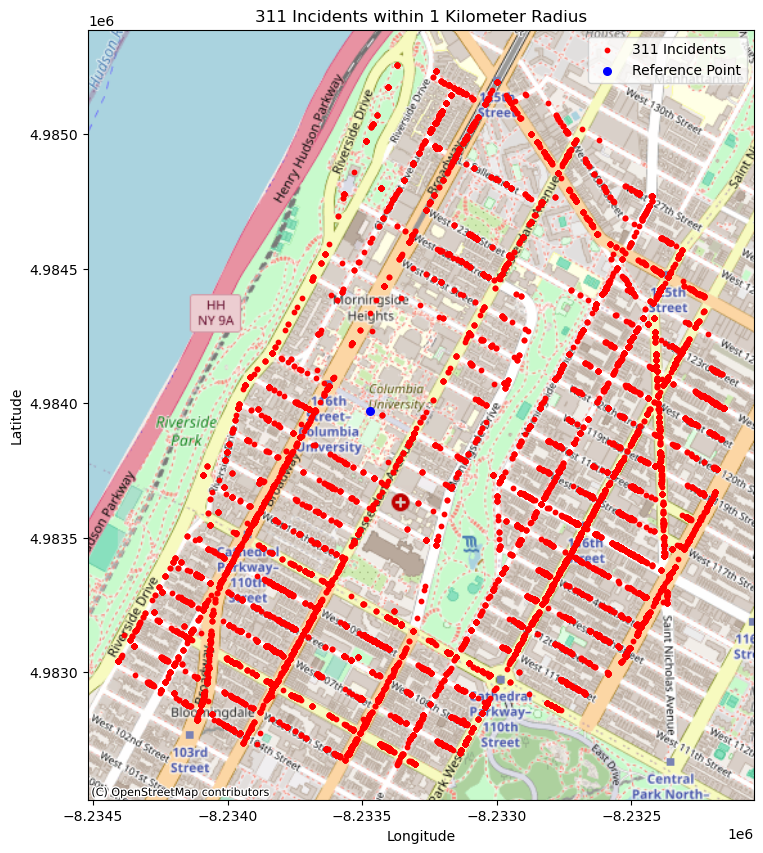

In [81]:
#5
def plot_nearby_311_incidents(engine: Engine, reference_point: Tuple[float, float]) -> None:
    # SQL query as a string to retrieve 311 incidents within a specific date range
    query: str = """
    SELECT latitude, longitude
    FROM three11s
    WHERE created_date BETWEEN '2023-01-01' AND '2023-09-30';
    """
    df: DataFrame = pd.read_sql(query, engine)

    # Convert the DataFrame to a GeoDataFrame
    gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )

    # Filter out invalid or empty geometries
    gdf = gdf[gdf['geometry'].is_valid & ~gdf['geometry'].is_empty]

    # Define the reference point as a Shapely Point geometry
    ref_point = Point(reference_point[1], reference_point[0])

    # Calculate the distance between each incident and the reference point
    gdf['distance'] = gdf['geometry'].apply(lambda x: distance((x.y, x.x), reference_point).km)

    # Filter incidents that are within a 1-kilometer radius of the reference point
    nearby_incidents: gpd.GeoDataFrame = gdf[gdf['distance'] <= 1]

    # Convert the GeoDataFrames to Web Mercator projection for plotting with contextily
    gdf_web_mercator: gpd.GeoDataFrame = nearby_incidents.to_crs(epsg=3857)
    ref_point_web_mercator = gpd.GeoSeries([ref_point], crs="EPSG:4326").to_crs(epsg=3857)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_web_mercator.plot(ax=ax, markersize=10, color='red', label='311 Incidents')
    ref_point_web_mercator.plot(ax=ax, markersize=30, color='blue', label='Reference Point')

    # Add a contextily basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('311 Incidents within 1 Kilometer Radius')
    plt.legend()
    plt.show()

# Example reference point (replace with the actual point)
reference_point: Tuple[float, float] = (40.80737875669467, -73.96253174434912) 
plot_nearby_311_incidents(engine, reference_point)


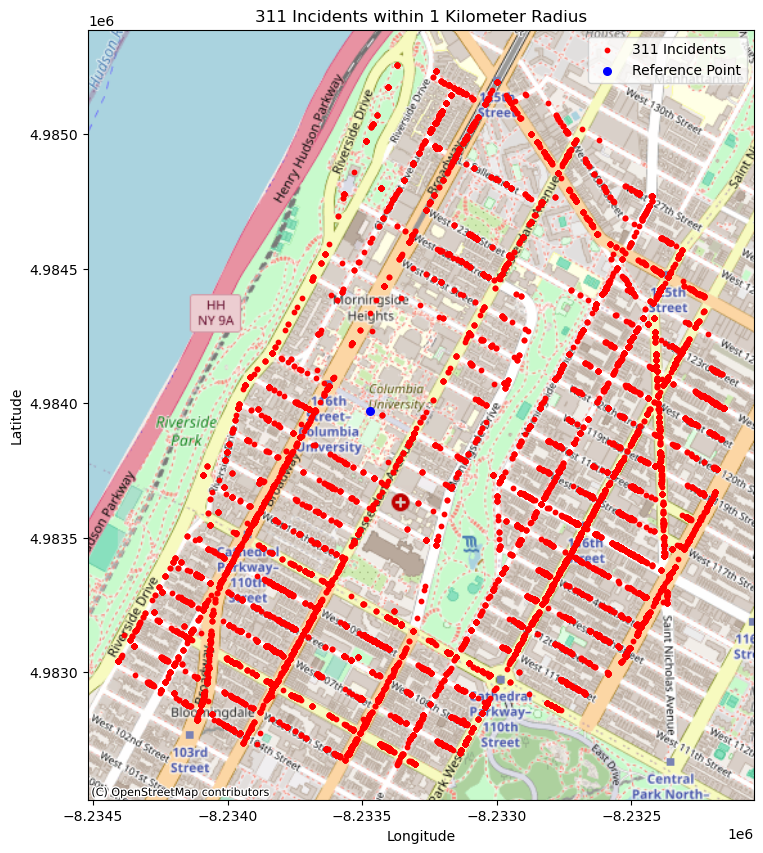

.
----------------------------------------------------------------------
Ran 1 test in 291.439s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [80]:
#unit test
class TestPlotplotnearby311incidents(unittest.TestCase):
    def test_plot_nearby_311_incidents(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Example reference point (latitude and longitude)
        reference_point = (40.80737875669467, -73.96253174434912)

        # Initialize the variable to None to catch exceptions
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            # Call the plot_nearby_311_incidents function with the test engine and reference point
            plot_nearby_311_incidents(engine, reference_point)

            # Set exception_raised to False if the function call is successful
            exception_raised = False
        except Exception as e:
            # If an exception is raised during the function call, set exception_raised to True and store the exception
            exception_raised = True
            raised_exception = e

        # Assertions
        # Check if the function call raised an exception, and if so, provide an error message
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotplotnearby311incidents)

# Run the tests
unittest.TextTestRunner().run(suite)


In [83]:
class TestPlotplotnearby311incidents(unittest.TestCase):
    """A unit test suite for the plot_nearby_311_incidents function."""

    def test_plot_nearby_311_incidents(self):
        """
        Test the plot_nearby_311_incidents function.

        This test case initializes a test database engine, provides an example reference point,
        calls the plot_nearby_311_incidents function, and verifies that it can be executed without raising an exception.

        Args:
            engine (sqlalchemy.engine.base.Engine): SQLAlchemy engine for connecting to the database.
            reference_point (tuple): A tuple containing latitude and longitude coordinates (float) as a reference point.

        Returns:
            None

        Raises:
            AssertionError: If the function raises an exception, this test case will fail.
        """

In [84]:
    """
    Visualizes 311 incidents within a 1-kilometer radius of a given reference point using a geographical plot.

    This function queries the 'three11s' table for latitude and longitude of incidents occurring between 
    January 1, 2023, and September 30, 2023. It converts these coordinates into a GeoDataFrame, and then 
    filters out zipcode within 1 kilometer of a specified reference point. The function then plots these 
    nearby zipcode and the reference point on a map.

    Args:
    - engine: The SQLAlchemy engine object for database connection and query execution.
    - reference_point: A tuple containing the latitude and longitude of the reference point (in the format (lat, lon)).
    
    Returns:
    None

    The function:
    - Retrieves latitude and longitude of 311 incidents from the database.
    - Converts the data into a GeoDataFrame and filters for valid geometries.
    - Calculates the distance of each incident from the reference point and filters incidents within 1 kilometer.
    - Plots the nearby incidents and the reference point using Matplotlib and GeoPandas.


    Note:
    - The function assumes the 'three11s' table is present in the database with latitude and longitude data.
    - It uses pandas, GeoPandas, and Shapely for data handling and Matplotlib for plotting.
    - This function does not return any value; it directly displays the plot.
    """


"\nVisualizes 311 incidents within a 1-kilometer radius of a given reference point using a geographical plot.\n\nThis function queries the 'three11' table for latitude and longitude of incidents occurring between \nJanuary 1, 2023, and September 30, 2023. It converts these coordinates into a GeoDataFrame, and then \nfilters out incidents within 1 kilometer of a specified reference point. The function then plots these \nnearby incidents and the reference point on a map.\n\nArgs:\n- engine: The SQLAlchemy engine object for database connection and query execution.\n- reference_point: A tuple containing the latitude and longitude of the reference point (in the format (lat, lon)).\n\nReturns:\nNone\n\nThe function:\n- Retrieves latitude and longitude of 311 incidents from the database.\n- Converts the data into a GeoDataFrame and filters for valid geometries.\n- Calculates the distance of each incident from the reference point and filters incidents within 1 kilometer.\n- Plots the nearby in

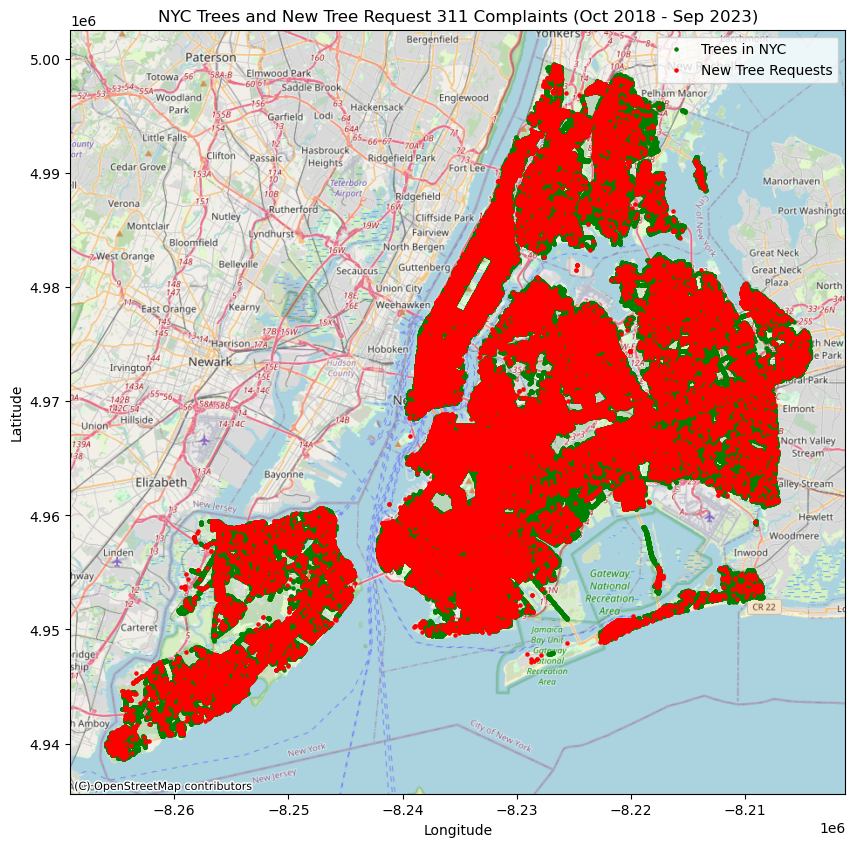

In [167]:
#6
%matplotlib inline
def plot_trees_and_new_tree_requests(engine: Engine) -> None:
    # SQL queries as strings
    tree_query: str = "SELECT latitude, longitude FROM trees;"
    complaint_query: str = """
    SELECT latitude, longitude
    FROM three11s
    WHERE complaint_type = 'New Tree Request'
    AND created_date BETWEEN '2018-10-01' AND '2023-09-30';
    """

    # Execute the SQL queries and retrieve the data
    tree_df: DataFrame = pd.read_sql(tree_query, engine)
    complaint_df: DataFrame = pd.read_sql(complaint_query, engine)

    # Convert the DataFrames to GeoDataFrames with proper geometry column
    tree_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(
        tree_df, 
        geometry=gpd.points_from_xy(tree_df.longitude, tree_df.latitude),
        crs="EPSG:4326"
    )
    complaint_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(
        complaint_df, 
        geometry=gpd.points_from_xy(complaint_df.longitude, complaint_df.latitude),
        crs="EPSG:4326"
    )

    # Transform the GeoDataFrames to Web Mercator (EPSG:3857) for contextily
    tree_gdf = tree_gdf.to_crs(epsg=3857)
    complaint_gdf = complaint_gdf.to_crs(epsg=3857)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot trees in green and label them as "Trees in NYC"
    tree_gdf.plot(ax=ax, markersize=5, color='green', label='Trees in NYC')
    
    # Plot new tree requests in red and label them as "New Tree Requests"
    complaint_gdf.plot(ax=ax, markersize=5, color='red', label='New Tree Requests')

    # Add a basemap from contextily using OpenStreetMap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Set axis labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('NYC Trees and New Tree Request 311 Complaints (Oct 2018 - Sep 2023)')
    
    # Display the legend
    plt.legend()
    
    # Show the plot
    plt.show()

# Call the function with the provided database engine
plot_trees_and_new_tree_requests(engine)



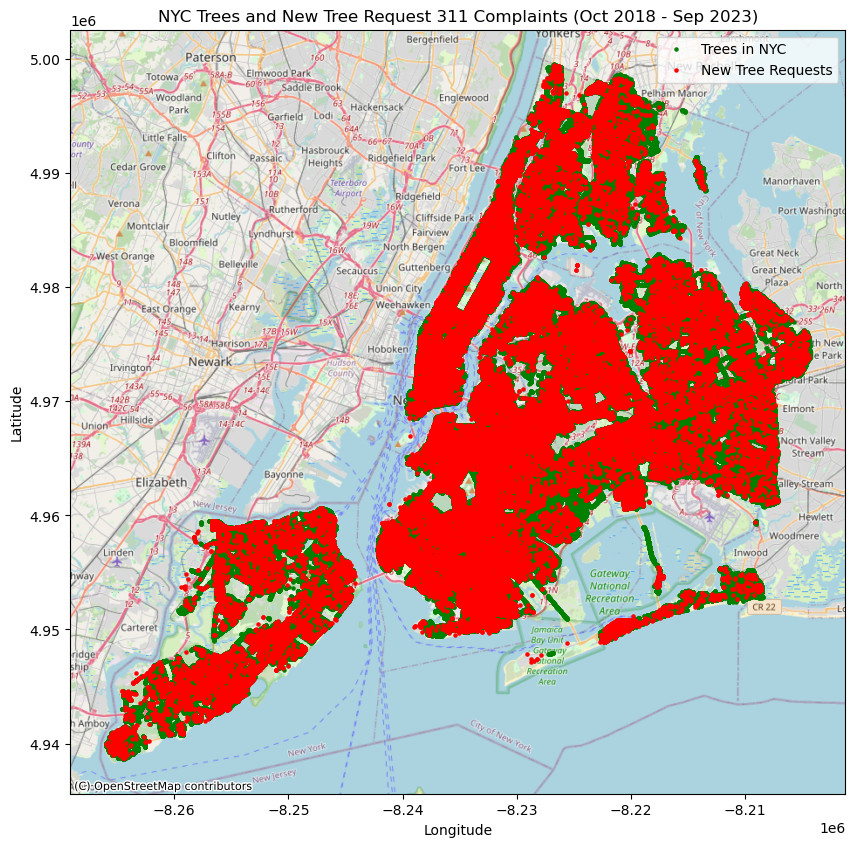

.
----------------------------------------------------------------------
Ran 1 test in 32.373s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [91]:
# Define a unit test class for the 'plot_trees_and_new_tree_requests' function
class TestPlotTreesAndNewTreeRequests(unittest.TestCase):
    def test_plot_trees_and_new_tree_requests(self):
        # Setup: create a test engine (replace with your test database credentials)
        engine = create_engine('postgresql://localhost/FinalProject4501')

        # Initialize the variable to None to capture any exceptions
        raised_exception = None

        # Call the function inside a try-except block to catch exceptions
        try:
            plot_trees_and_new_tree_requests(engine)
            # Set 'exception_raised' to False if the function runs without errors
            exception_raised = False
        except Exception as e:
            # Set 'exception_raised' to True and store the exception if an error occurs
            exception_raised = True
            raised_exception = e

        # Assertions: Check if the function ran without raising exceptions
        self.assertFalse(exception_raised, f"Function raised an exception: {raised_exception}")

# Create a test suite for the 'plot_trees_and_new_tree_requests' function
suite = unittest.TestLoader().loadTestsFromTestCase(TestPlotTreesAndNewTreeRequests)

# Run the unit tests and display the results
unittest.TextTestRunner().run(suite)


In [92]:
class TestPlotTreesAndNewTreeRequests(unittest.TestCase):
    """
    A unit test suite for the plot_trees_and_new_tree_requests function.
    """

    def test_plot_trees_and_new_tree_requests(self):
        """
        Test the plot_trees_and_new_tree_requests function.

        This test case initializes a test database engine, calls the plot_trees_and_new_tree_requests function,
        and verifies that it can be executed without raising an exception.

        Args:
            engine (sqlalchemy.engine.base.Engine): SQLAlchemy engine for connecting to the database.

        Returns:
            None

        Raises:
            AssertionError: If the function raises an exception, this test case will fail.
        """

In [93]:
    """
    Plot trees and new tree request locations in NYC.

    This function retrieves data for existing trees and new tree requests in New York City
    from a database using SQL queries. It then converts these data sets into GeoDataFrames 
    and plots them on a map. The existing trees are represented as green points, and the 
    new tree requests, gathered from 311 complaints between October 2018 and September 2023,
    are shown as red points.

    Arguments:
    engine (SQLAlchemy Engine): A SQLAlchemy Engine object used to connect to and query the database.

    Returns:
    None: This function does not return any value. It displays a matplotlib plot showing the 
    distribution of trees and new tree requests across New York City.
    """

'\nPlot trees and new tree request locations in NYC.\n\nThis function retrieves data for existing trees and new tree requests in New York City\nfrom a database using SQL queries. It then converts these data sets into GeoDataFrames \nand plots them on a map. The existing trees are represented as green points, and the \nnew tree requests, gathered from 311 complaints between October 2018 and September 2023,\nare shown as red points.\n\nArguments:\nengine (SQLAlchemy Engine): A SQLAlchemy Engine object used to connect to and query the database.\n\nReturns:\nNone: This function does not return any value. It displays a matplotlib plot showing the \ndistribution of trees and new tree requests across New York City.\n'